In [1]:
#import needed libs
import yfinance as yf
import pandas as pd
import tensorflow as tf
tf.random.set_seed(42)
from sklearn.preprocessing import MinMaxScaler
import numpy as np
np.random.seed(42)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

In [2]:
#download data from yahoo

ticker = 'GC=F'

# Define the start and end dates for the historical data
start_date = '2000-01-01'
end_date = '2024-01-01'


# Retrieve the historical data
gold_data = yf.download(ticker, start=start_date, end=end_date)
gold_data.to_csv("/content/drive/My Drive/gold.csv")
gold_data.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-08-30,273.899994,273.899994,273.899994,273.899994,273.899994,0
2000-08-31,274.799988,278.299988,274.799988,278.299988,278.299988,0
2000-09-01,277.000000,277.000000,277.000000,277.000000,277.000000,0
2000-09-05,275.799988,275.799988,275.799988,275.799988,275.799988,2
2000-09-06,274.200012,274.200012,274.200012,274.200012,274.200012,0


In [3]:
df = pd.read_csv("/content/drive/My Drive/gold.csv")

In [4]:
#keep only needed columns
df = df[['Date','Close']]

In [5]:
#checking for missed values
print("\nChecking for missing values:\n", df.isnull().sum())


Checking for missing values:
 Date     0
Close    0
dtype: int64


In [6]:
#to plot easier later and to make more sense of the data we use the date columna as index
df.index = pd.to_datetime(df['Date'],format="%Y-%m-%d")
df[:5]

,Date,Close
Date,,
2000-08-30,2000-08-30,273.899994
2000-08-31,2000-08-31,278.299988
2000-09-01,2000-09-01,277.000000
2000-09-05,2000-09-05,275.799988
2000-09-06,2000-09-06,274.200012


In [7]:
#we scale the data for better training
close_prices = df['Close'].values.reshape(-1, 1)  # Reshape for scaler input

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Fit scaler to data and transform
scaled_close_prices = scaler.fit_transform(close_prices)

#add scaled column to data frame
df['Scaled'] = scaled_close_prices
df.head()

,Date,Close,Scaled
Date,,,
2000-08-30,2000-08-30,273.899994,0.010291
2000-08-31,2000-08-31,278.299988,0.012700
2000-09-01,2000-09-01,277.000000,0.011988
2000-09-05,2000-09-05,275.799988,0.011331
2000-09-06,2000-09-06,274.200012,0.010455


<Axes: xlabel='Date'>

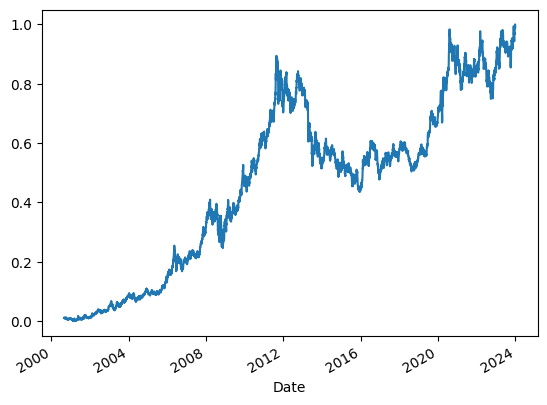

In [8]:
#keep only the column we need which is scaled data 
df = df['Scaled']
#we plot to see trends
df.plot()

In [9]:
#we need X and y in the shape of series and one output similar to this
# X =[[1],[2],[3],[4],[5]] Y=[6]
#this function do just that
def df_to_x_y(df,window_size=10):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range (len(df_as_np)-window_size):
    #take a window size inputs starting from i
    row = [[a] for a in df_as_np[i:i+window_size]]
    X.append(row)
    #take the input after window size inputs
    label = df_as_np[i+window_size]
    y.append(label)
  return np.array(X),np.array(y)

In [10]:
#define how many past values we need to predict next value
WINDOW_SIZE = 10
X,y = df_to_x_y(df,WINDOW_SIZE)
X.shape,y.shape

((5845, 10, 1), (5845,))

In [11]:
#we take 80% training size set
train_size = (int)(len(X)*0.8)

#the earlier data are the for training
X_train,y_train = X[:train_size],y[:train_size]
X_test,y_test = X[train_size:],y[train_size:]

X_train.shape ,y_train.shape, X_test.shape,y_test.shape

((4676, 10, 1), (4676,), (1169, 10, 1), (1169,))

In [12]:
#we maintain same number of epochs for all models for better comparision
EPOCHS = 30
BATCH_SIZE = 32

#define first model with units=64,learning rate=0.001,one LSTM layer,no dropout rate
model1 = Sequential()
model1.add(InputLayer((WINDOW_SIZE,1)))
model1.add(LSTM(64))
model1.add(Dense(8,'relu'))
model1.add(Dense(1,'linear'))
model1.compile(loss=MeanSquaredError(),optimizer=Adam(learning_rate=0.001))
history = model1.fit(X_train,y_train,epochs=EPOCHS,batch_size=BATCH_SIZE,verbose=0)
train_loss1 = history.history['loss']

#define second model with units=64,learning rate=0.0001,one LSTM layer,no dropout
model2 = Sequential()
model2.add(InputLayer((WINDOW_SIZE,1)))
model2.add(LSTM(64))
model2.add(Dense(8,'relu'))
model2.add(Dense(1,'linear'))
model2.compile(loss=MeanSquaredError(),optimizer=Adam(learning_rate=0.0001))
history = model2.fit(X_train,y_train,epochs=EPOCHS,batch_size=BATCH_SIZE,verbose=0)
train_loss2 = history.history['loss']

#define third model with units=64,learning rate=0.001,one LSTM layer,dropout rate = 0.2
model3 = Sequential()
model3.add(InputLayer((WINDOW_SIZE,1)))
model3.add(LSTM(64, dropout=0.2))
model3.add(Dense(8,'relu'))
model3.add(Dense(1,'linear'))
model3.compile(loss=MeanSquaredError(),optimizer=Adam(learning_rate=0.001))
history = model3.fit(X_train,y_train,epochs=EPOCHS,batch_size=BATCH_SIZE,verbose=0)
train_loss3 = history.history['loss']

#define fourth model with units=128,learning rate=0.001,one LSTM layer,no dropout
model4 = Sequential()
model4.add(InputLayer((WINDOW_SIZE,1)))
model4.add(LSTM(128))
model4.add(Dense(8,'relu'))
model4.add(Dense(1,'linear'))
model4.compile(loss=MeanSquaredError(),optimizer=Adam(learning_rate=0.001))
history = model4.fit(X_train,y_train,epochs=EPOCHS,batch_size=BATCH_SIZE,verbose=0)
train_loss4 = history.history['loss']

#define fifth model with units=128,learning rate=0.001,two LSTM layer,no dropout
model5 = Sequential()
model5.add(InputLayer((WINDOW_SIZE,1)))
model5.add(LSTM(128,return_sequences=True))
model5.add(LSTM(128))
model5.add(Dense(8,'relu'))
model5.add(Dense(1,'linear'))
model5.compile(loss=MeanSquaredError(),optimizer=Adam(learning_rate=0.001))
history = model5.fit(X_train,y_train,epochs=EPOCHS,batch_size=BATCH_SIZE,verbose=0)
train_loss5 = history.history['loss']


models = [model1,model2,model3,model4,model5]
train_losses = [train_loss1,train_loss2,train_loss3,train_loss4,train_loss5]
names = ['model1: units=64,learning rate=0.001,one LSTM layer,no dropout ',
          'model2: units=64,learning rate=0.0001,one LSTM layer,no dropout  ',
          'model3: units=64,learning rate=0.001,one LSTM layer,dropout rate = 0.2',
          'model4: units=128,learning rate=0.001,one LSTM layer,no dropout',
          'model5: units=128,learning rate=0.001,two LSTM layer,no dropout']

In [13]:
#we save the original correct data for test set in Y
y_test_flatten = y_test.flatten()
correct_original = scaler.inverse_transform(y_test_flatten.reshape(-1, 1))
Y = correct_original.flatten()


In [14]:
#calculate predicted values and evaluate predictions on test set
mse_vals=[]
rmse_vals=[]
test_predictions_per_model=[]

for model,loss,name in zip(models,train_losses,names):
  predicted_scaled = model.predict(X_test).flatten()
  predicted_original = scaler.inverse_transform(predicted_scaled.reshape(-1, 1))
  test_predictions = predicted_original.flatten()
  test_predictions_per_model.append(test_predictions)
  mse = mean_squared_error(test_predictions,Y)
  rmse = np.sqrt(mse)
  mse_vals.append(mse)
  rmse_vals.append(rmse)

37/37 [==============================] - 1s 10ms/step


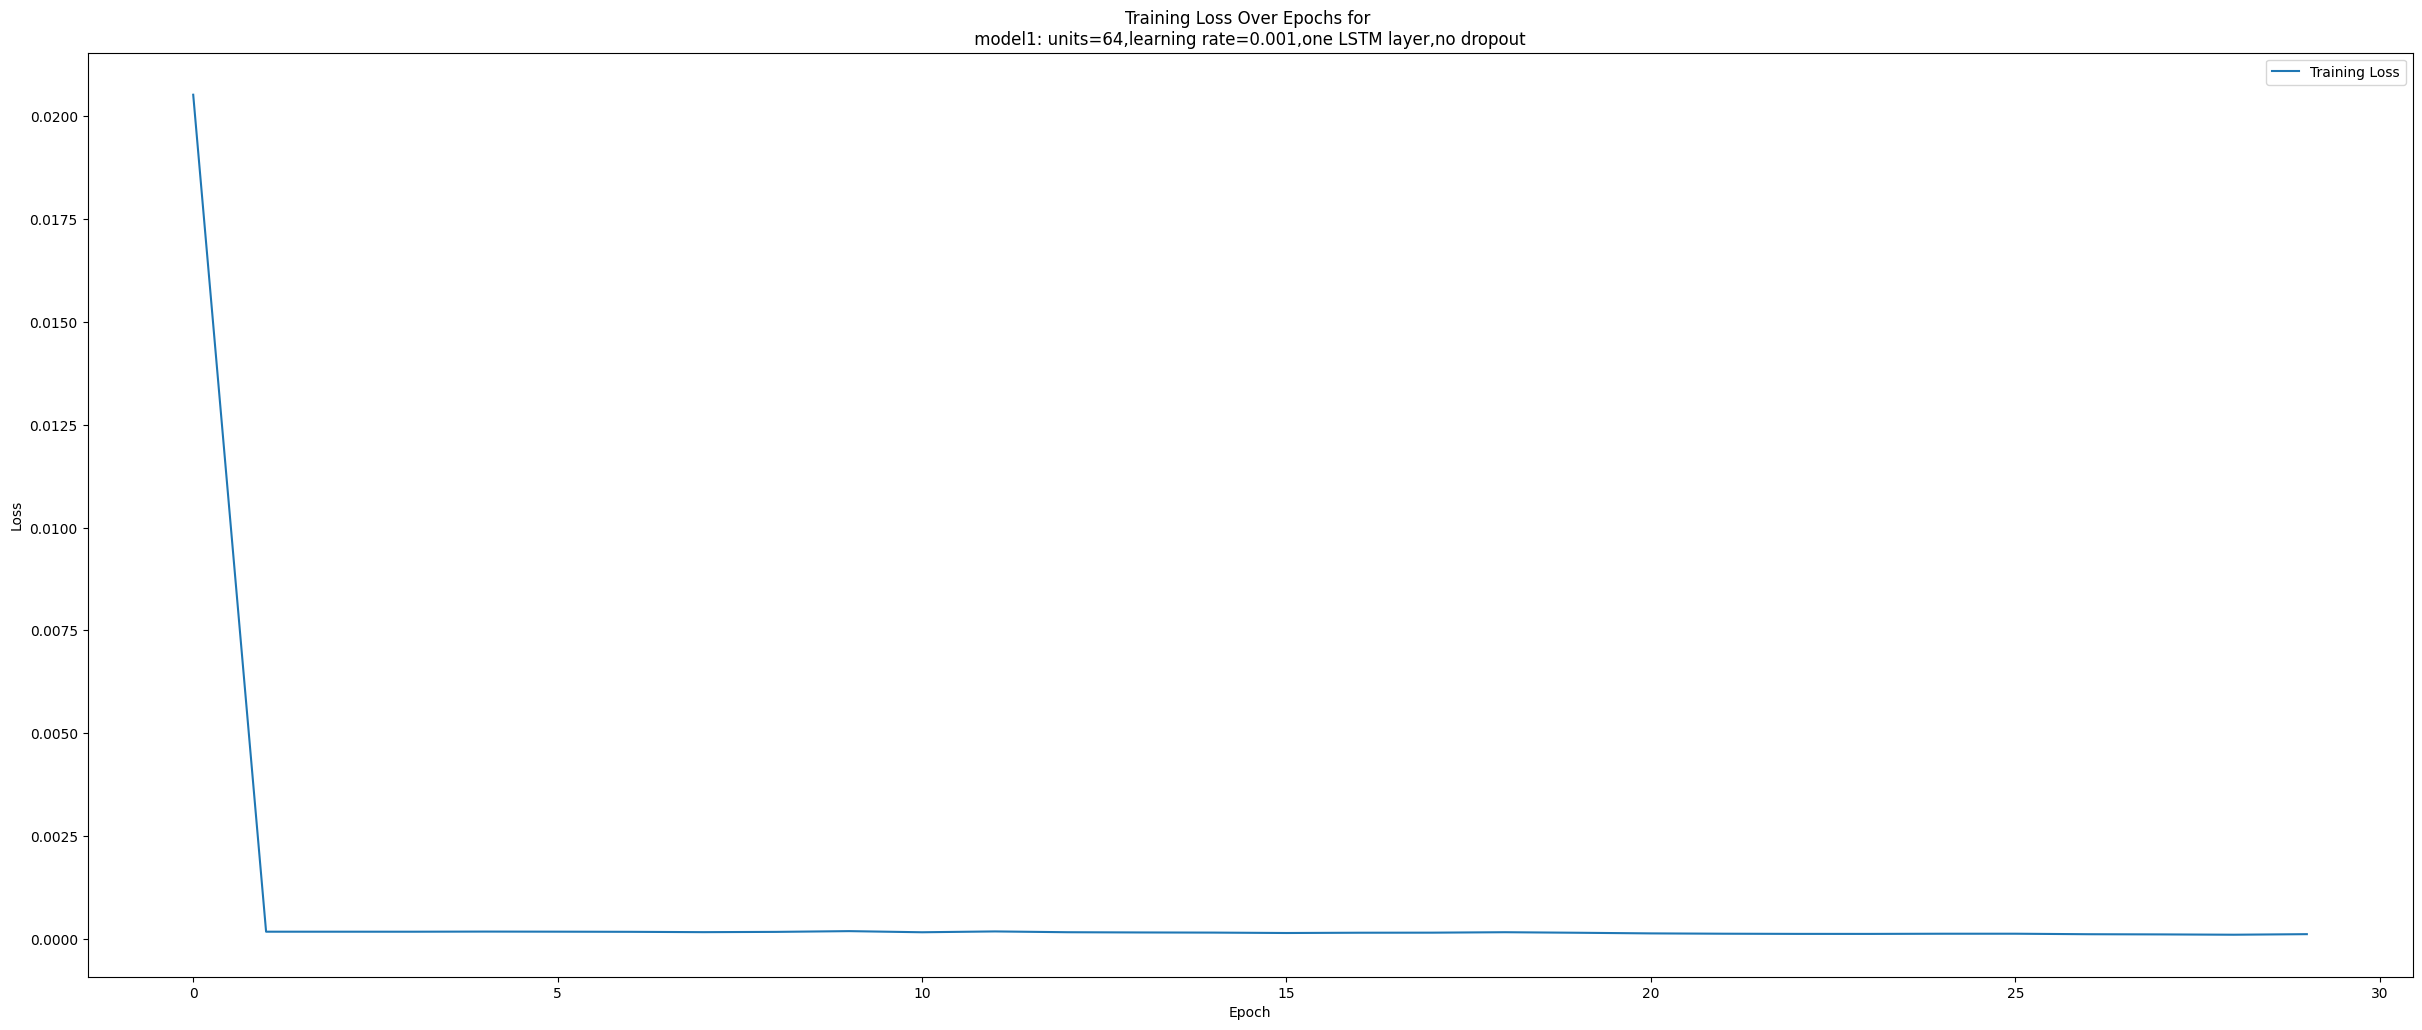

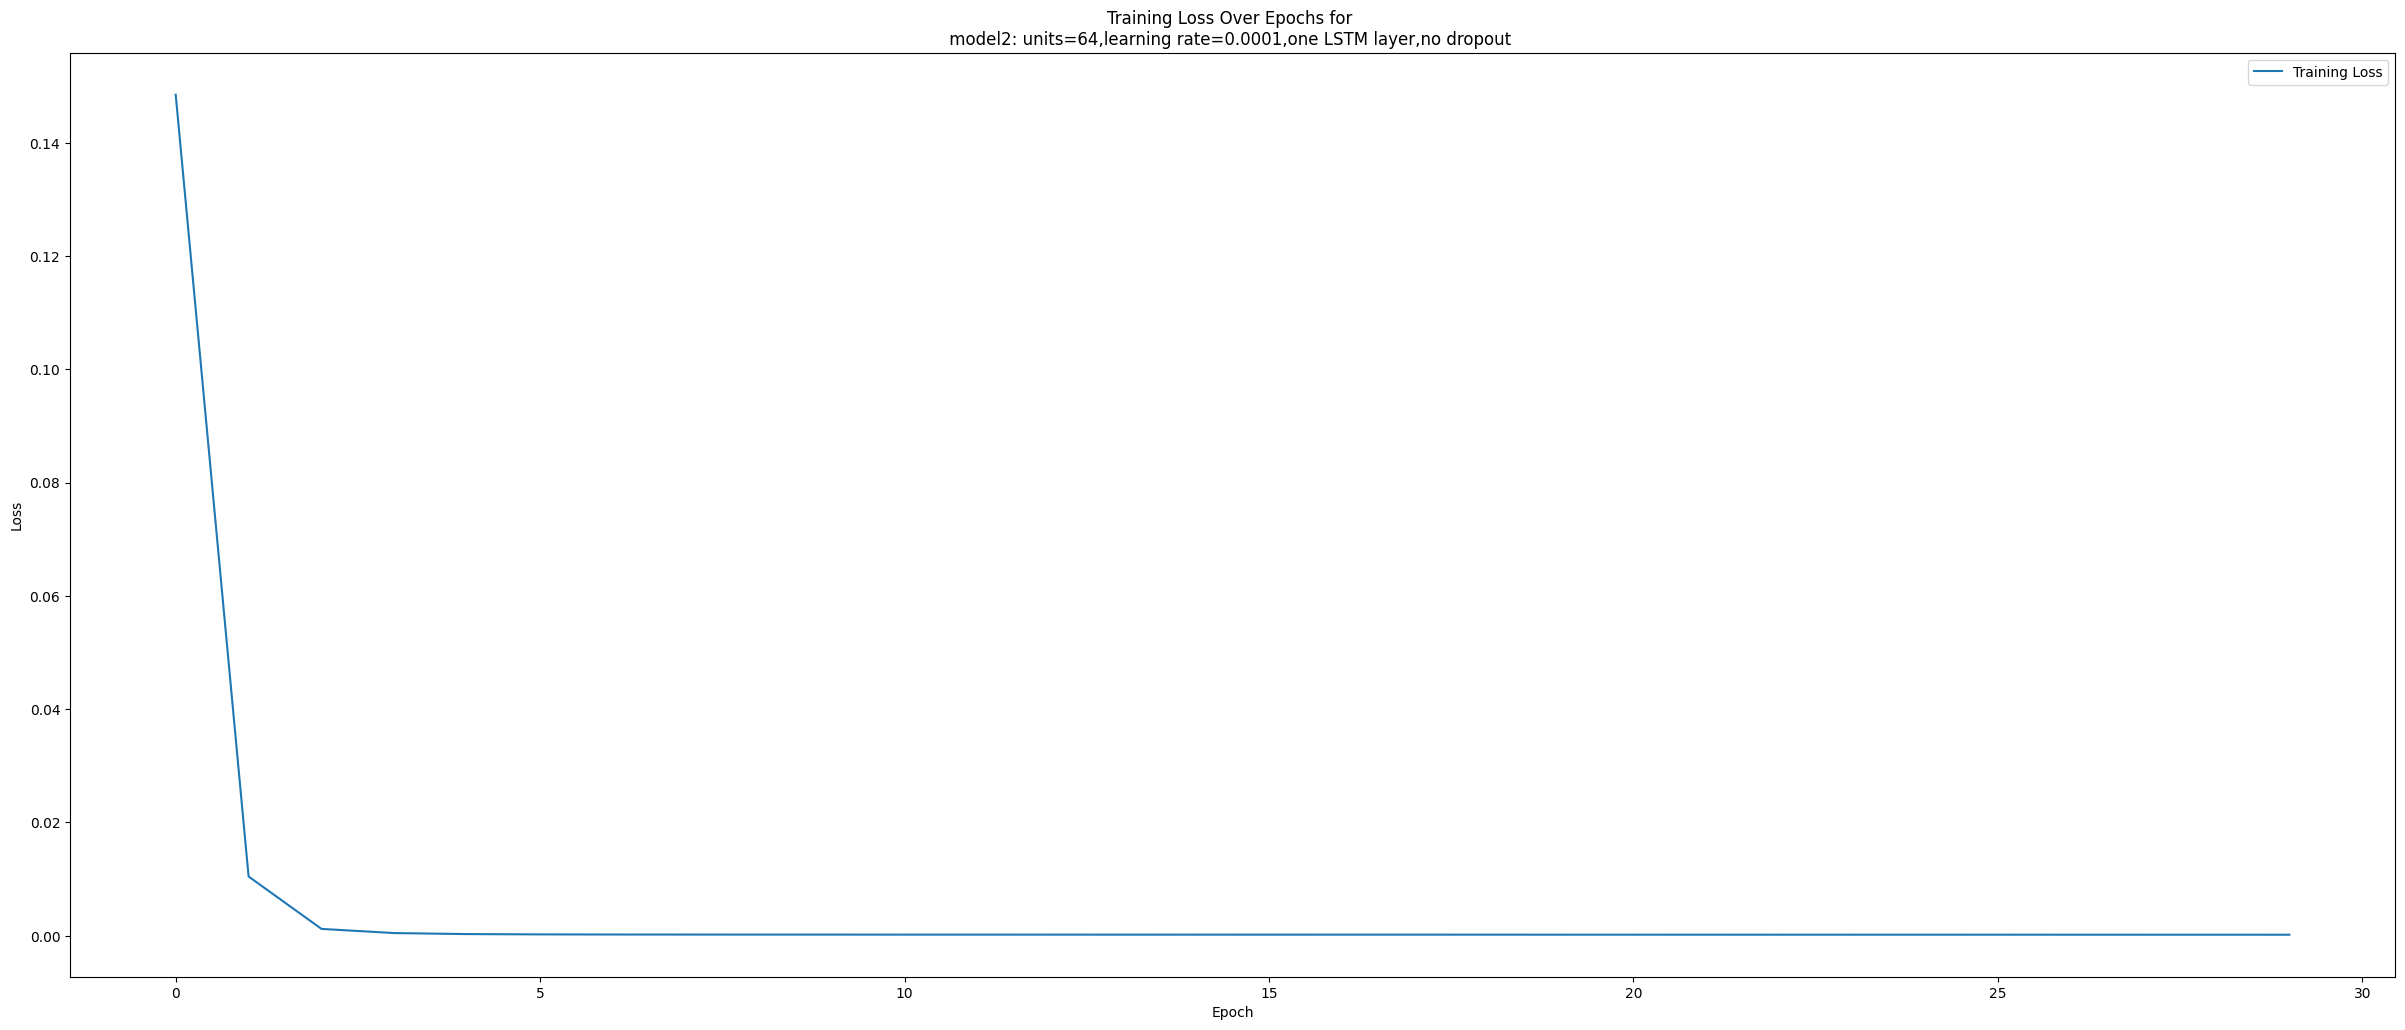

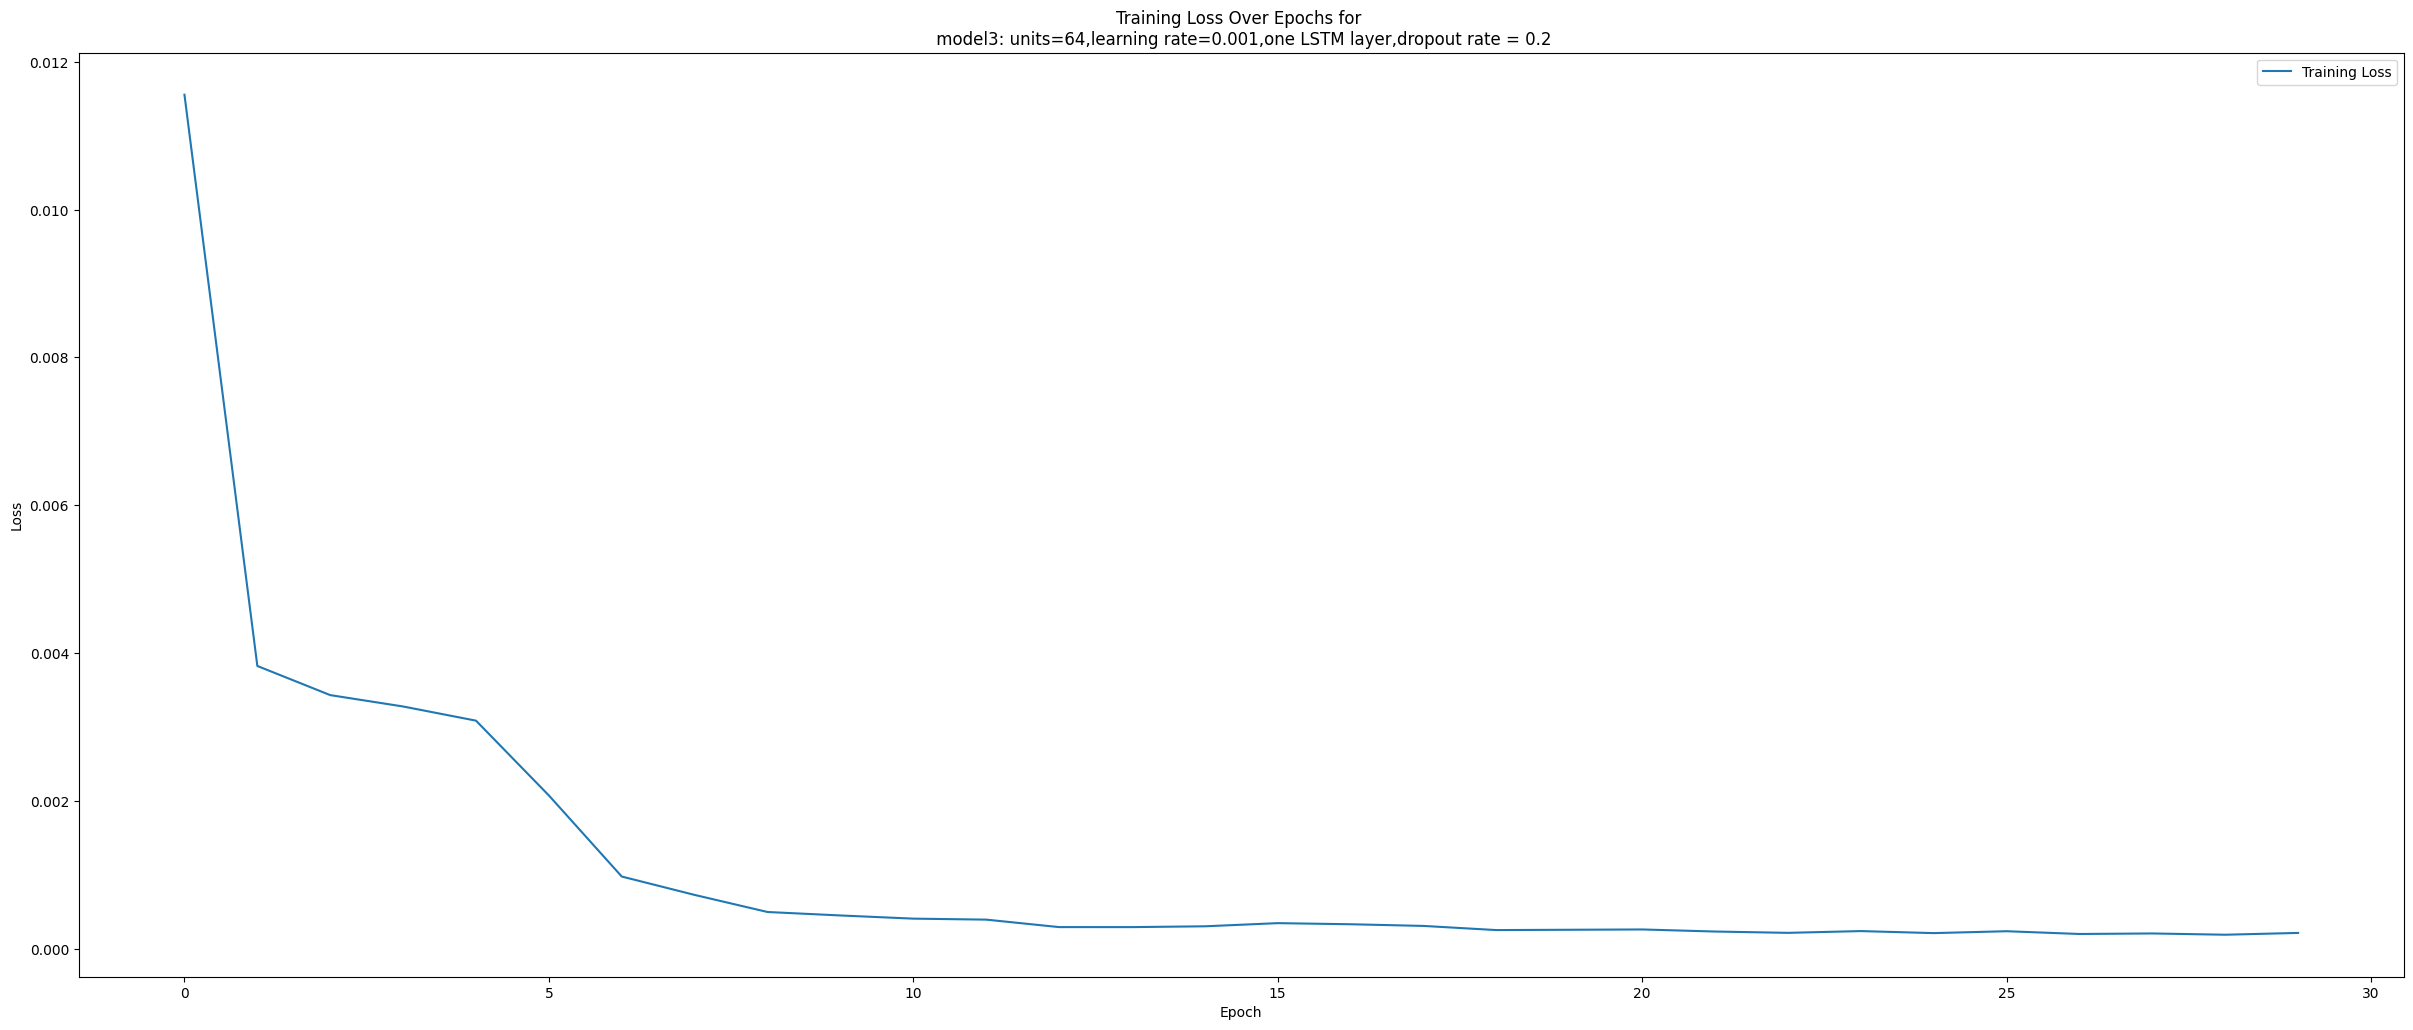

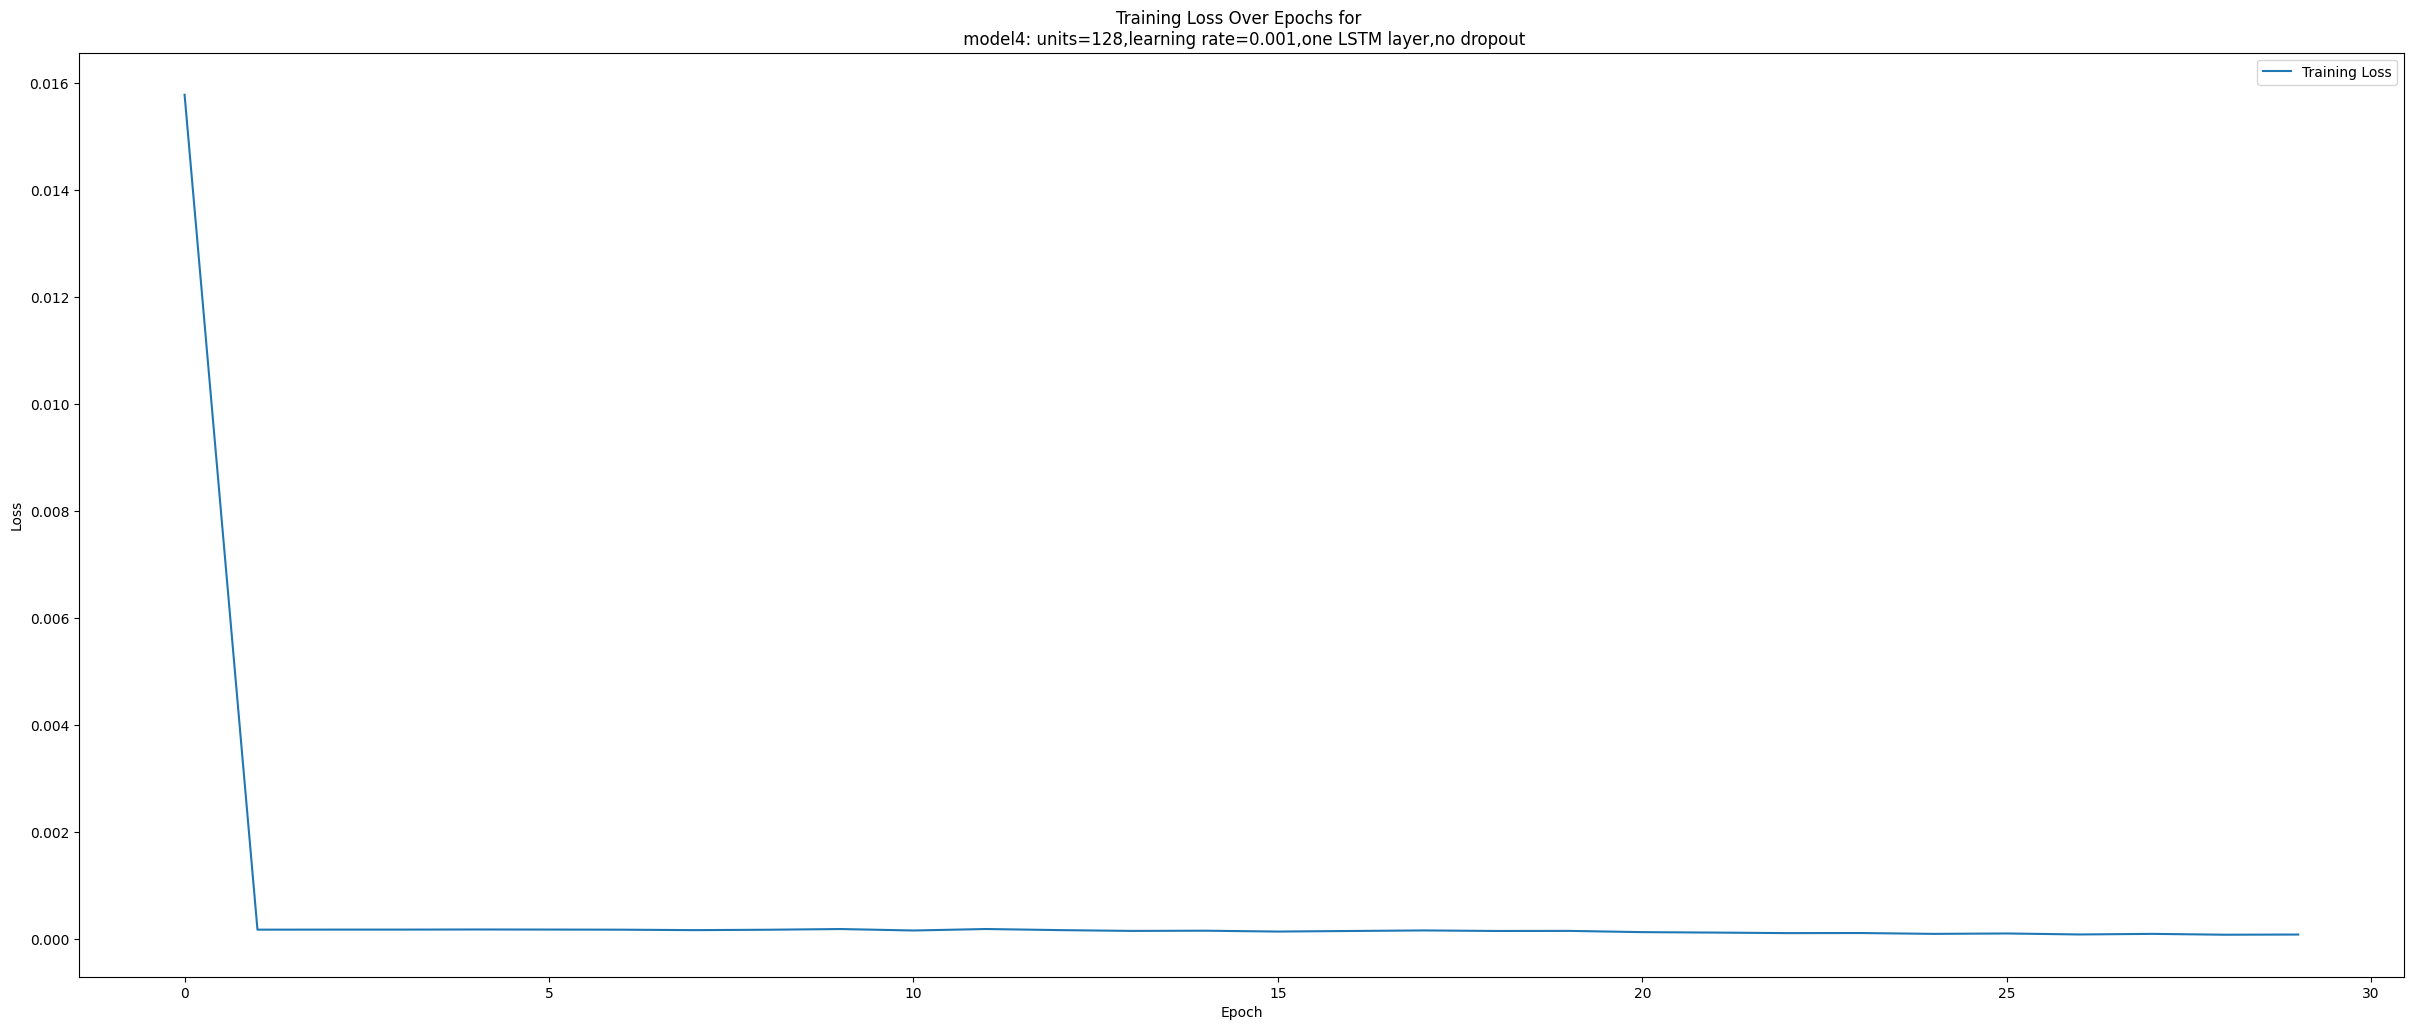

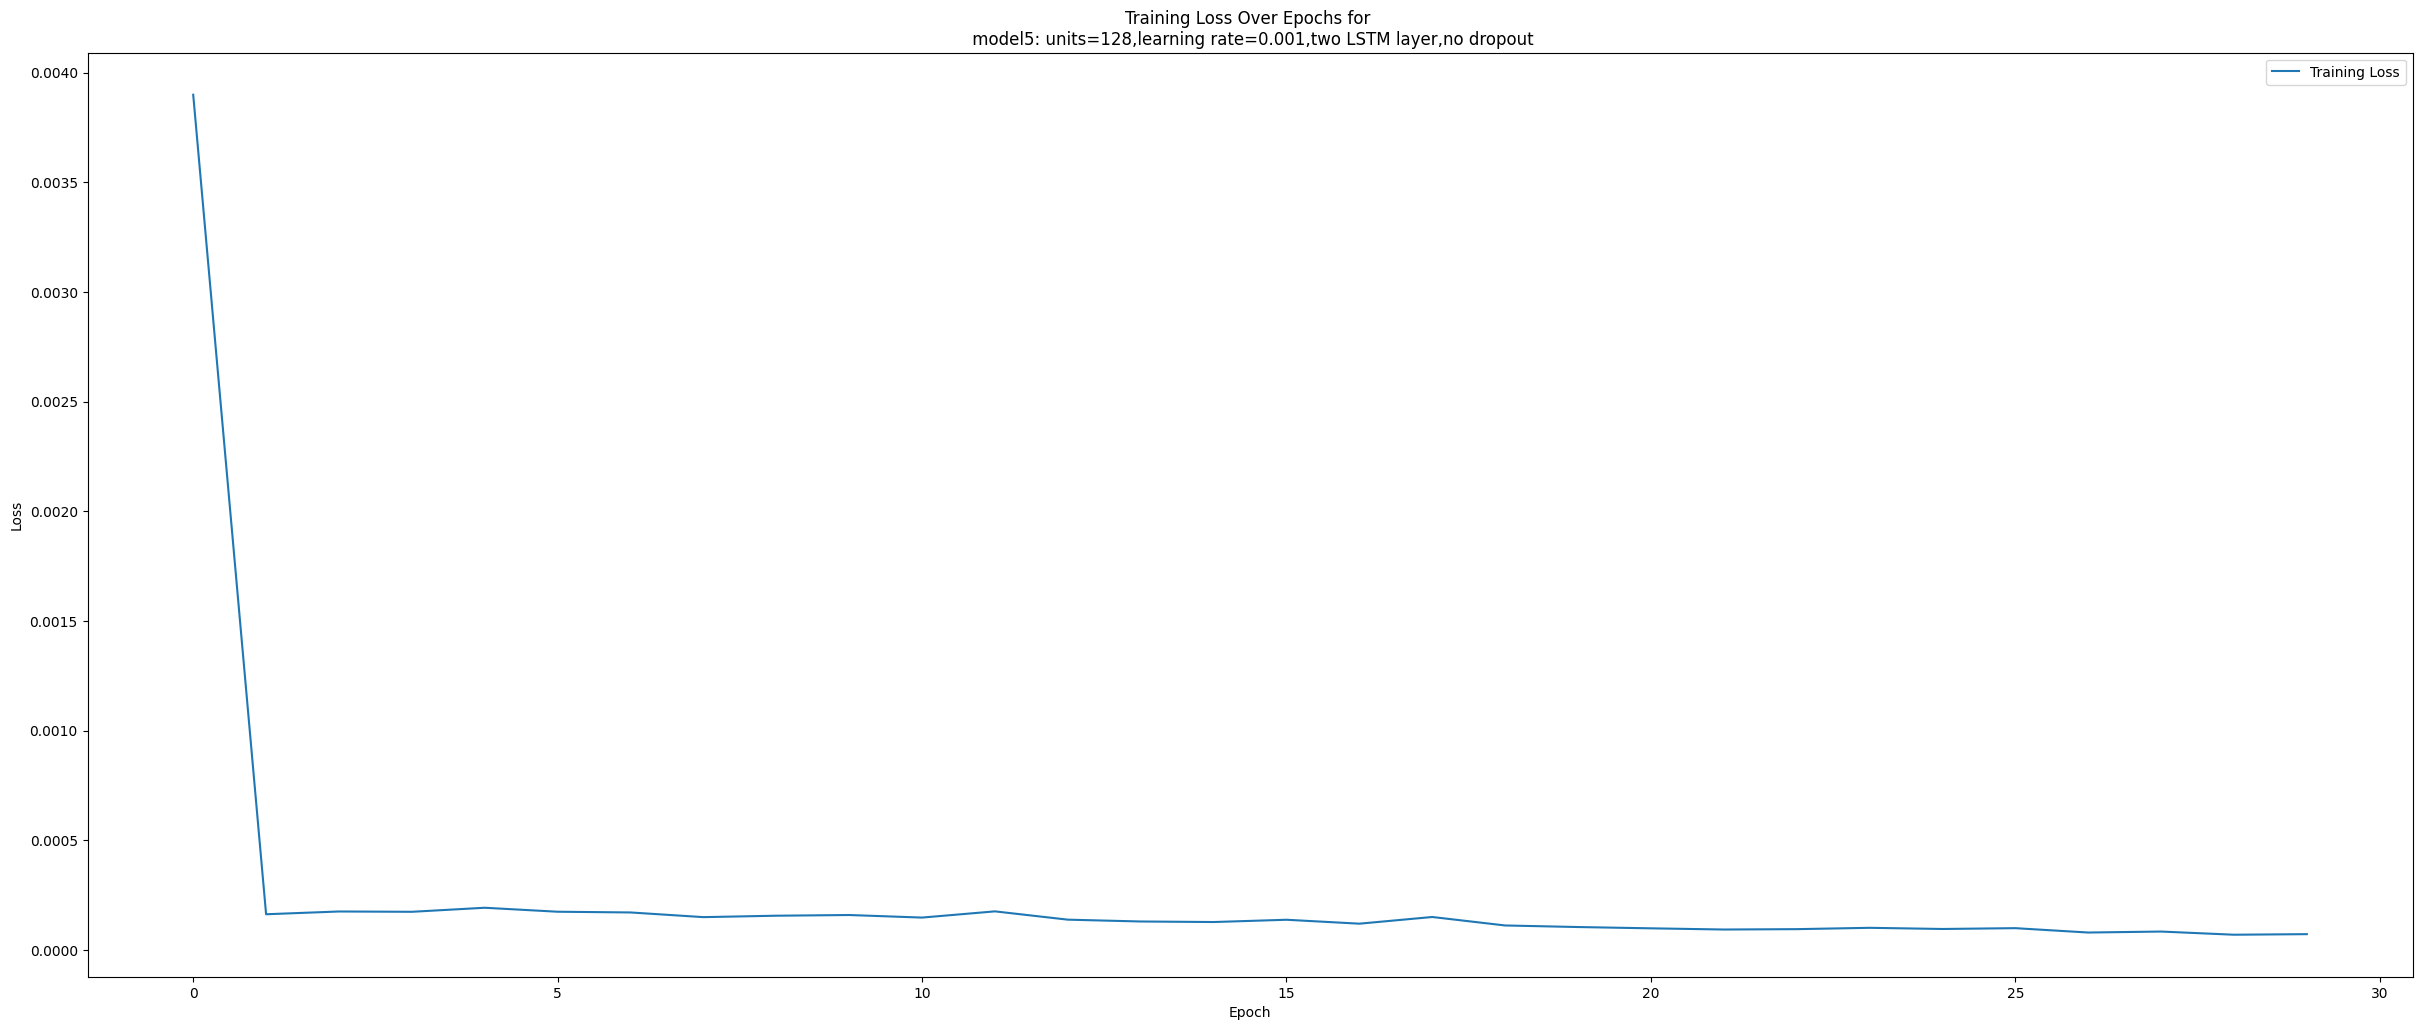

In [15]:
#Plot the training  losses during model training to understand convergence.
for loss,name in zip(train_losses,names):
  plt.figure(figsize=(30, 12))
  plt.plot(loss, label='Training Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title(f'Training Loss Over Epochs for \n {name}')
  plt.legend()
  plt.show()
  print()

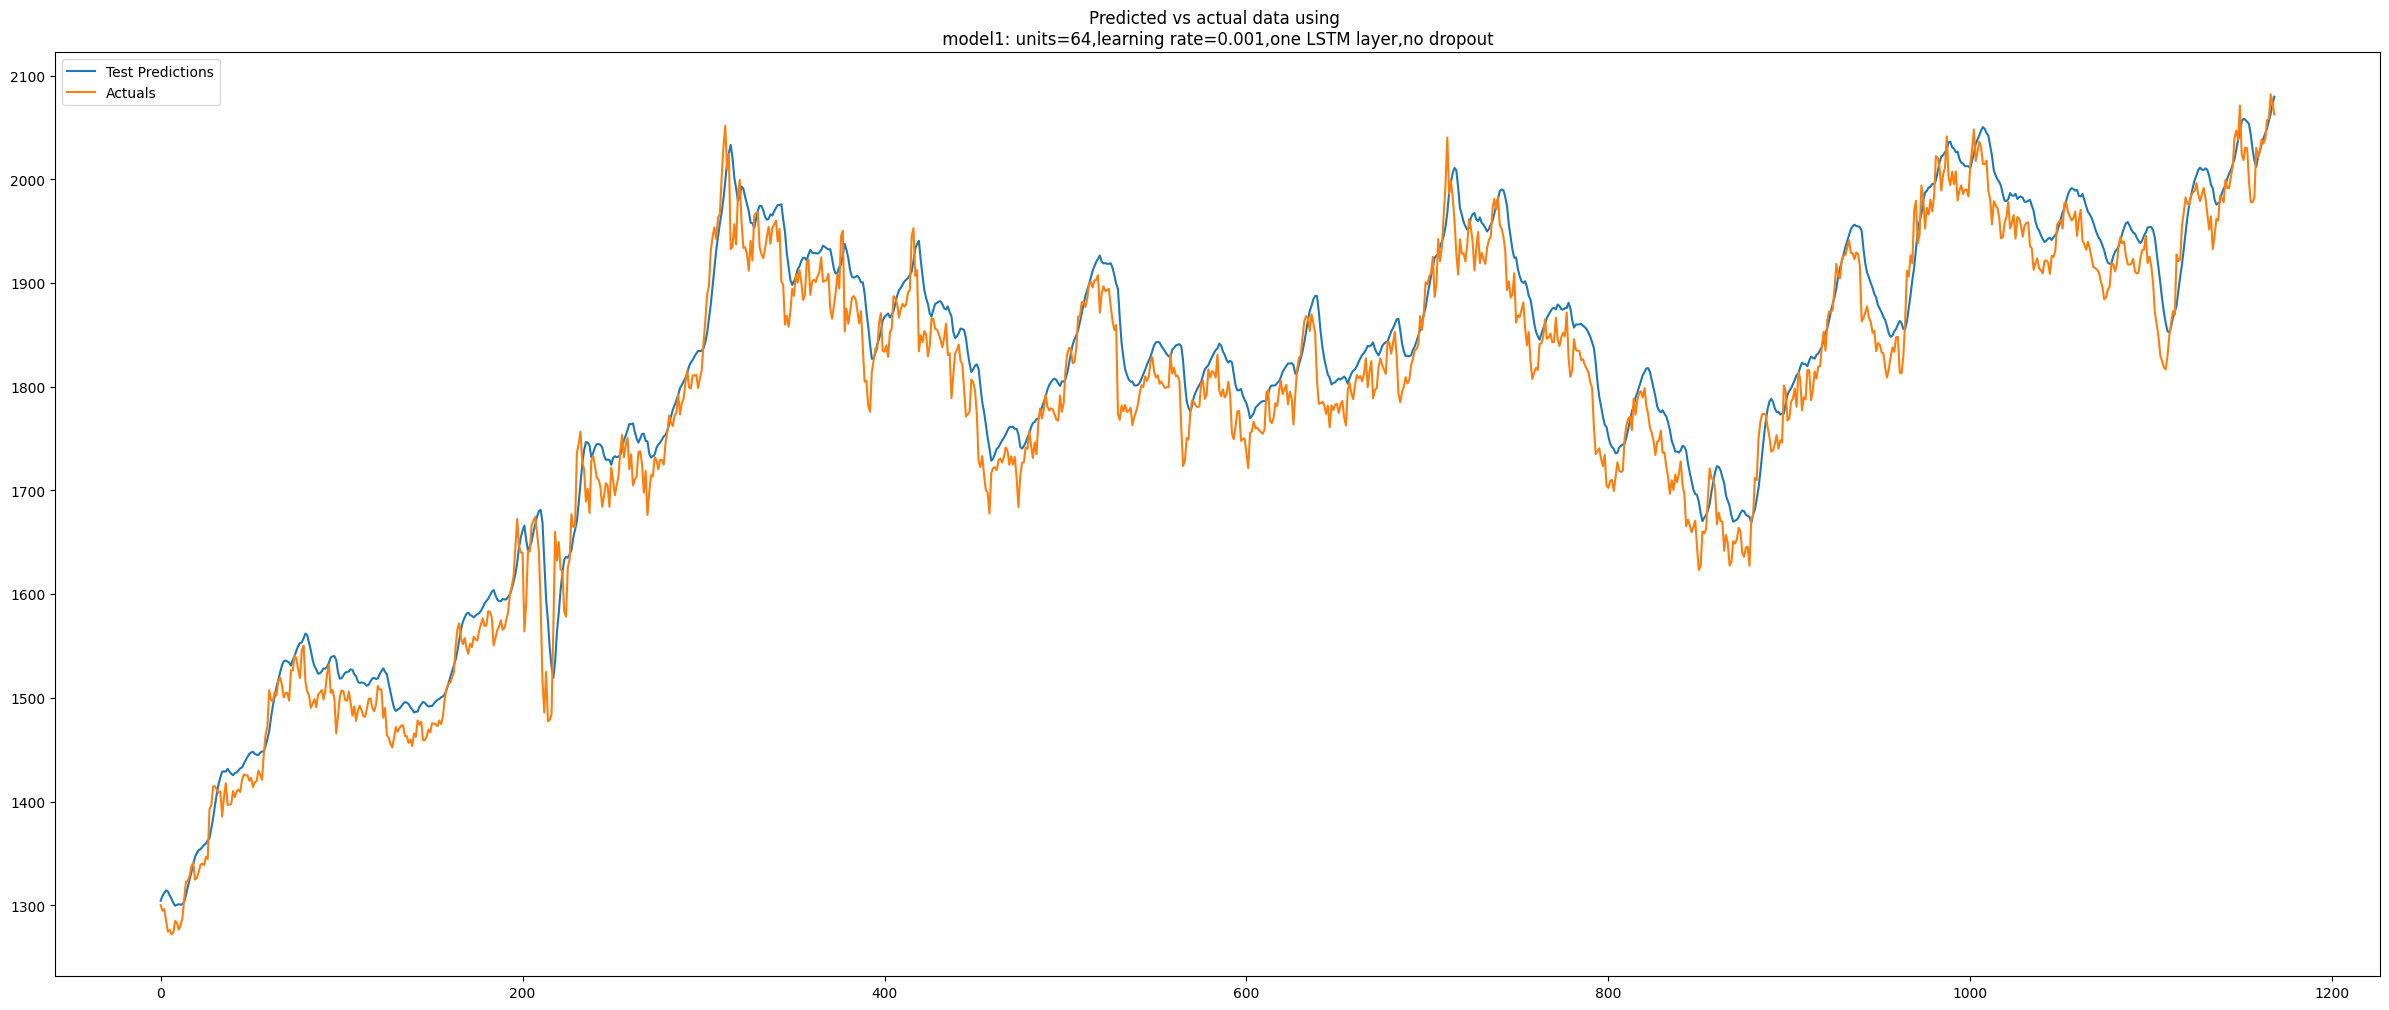

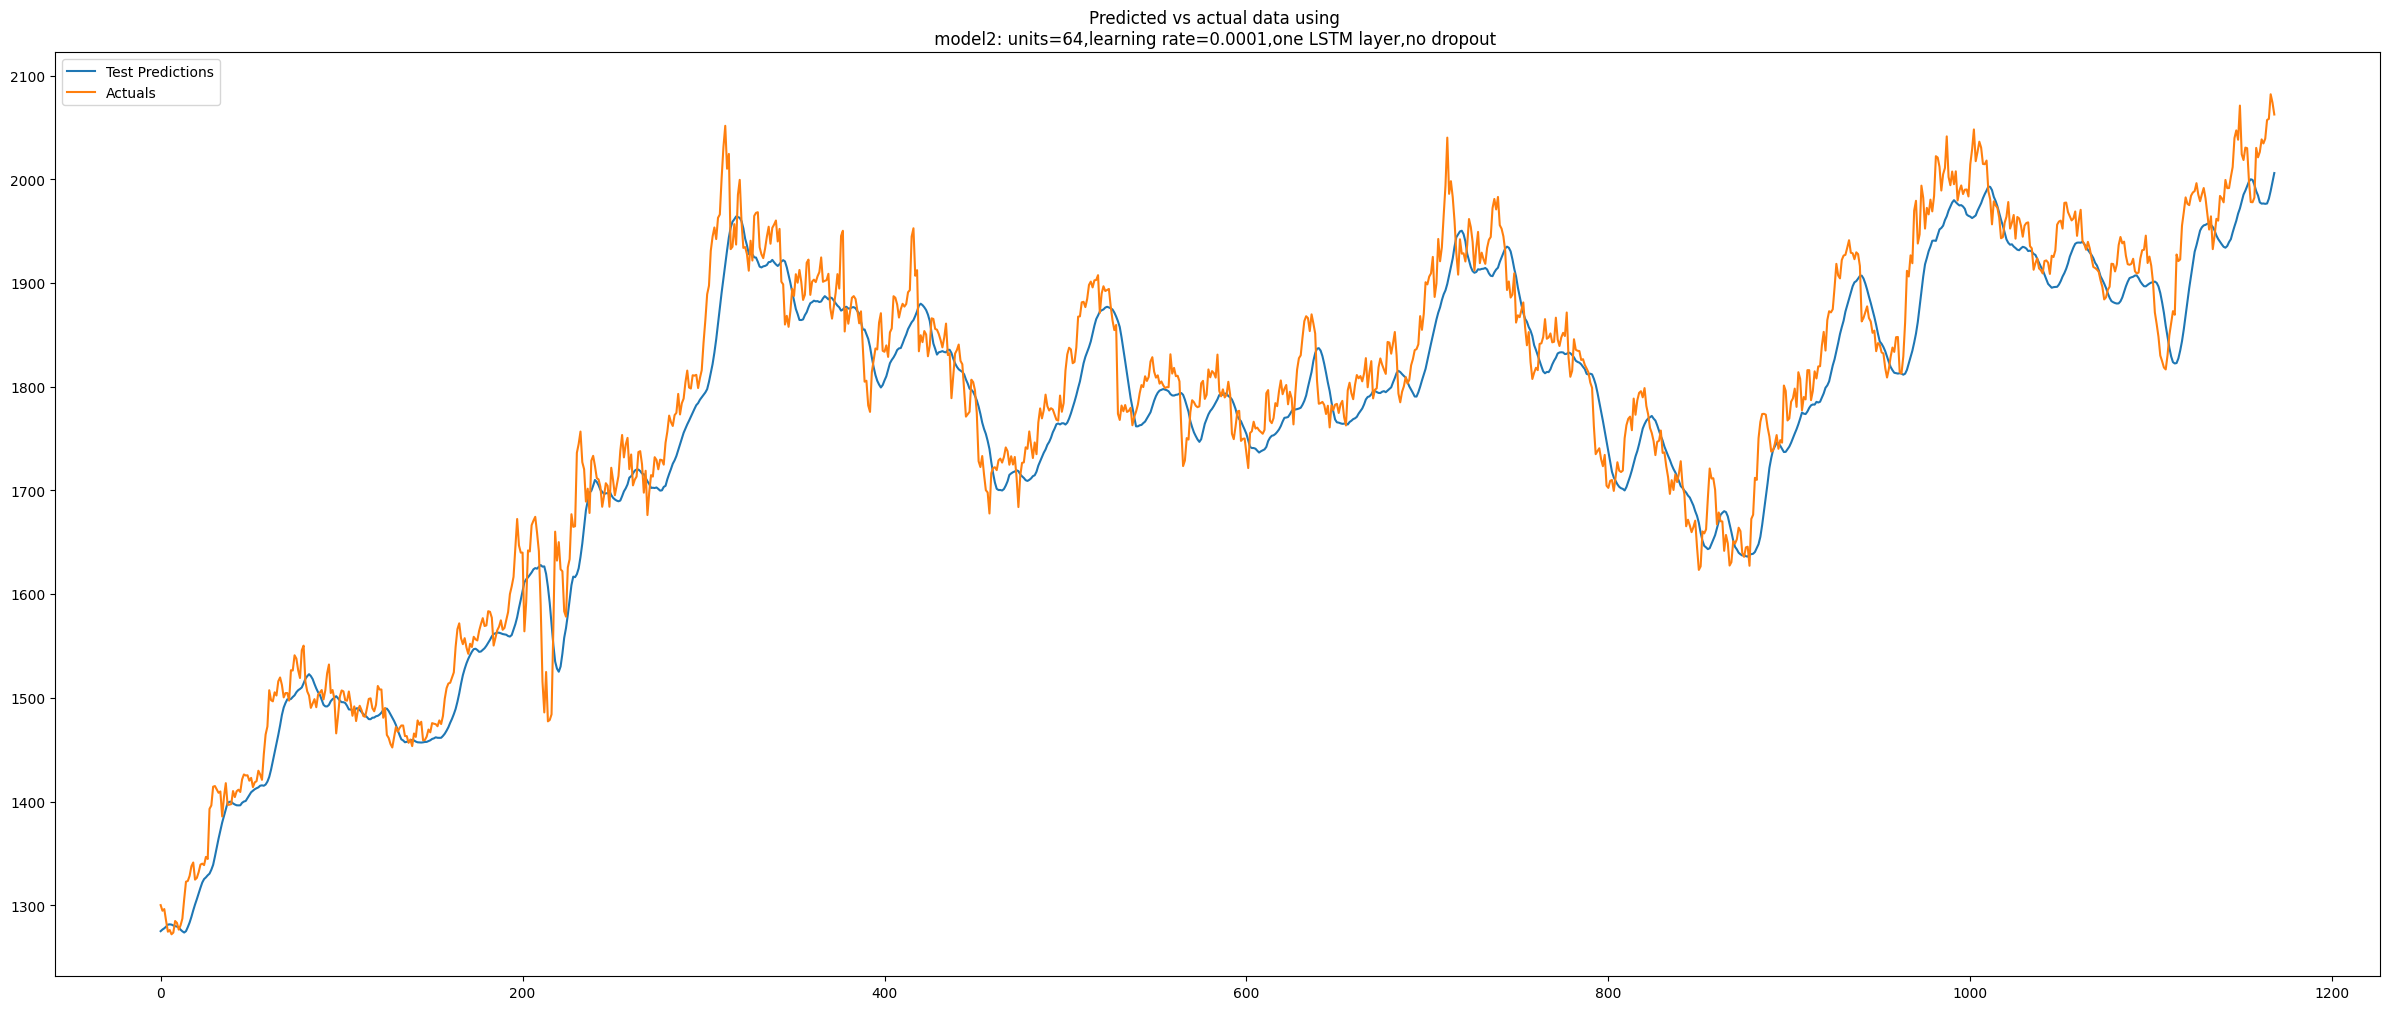

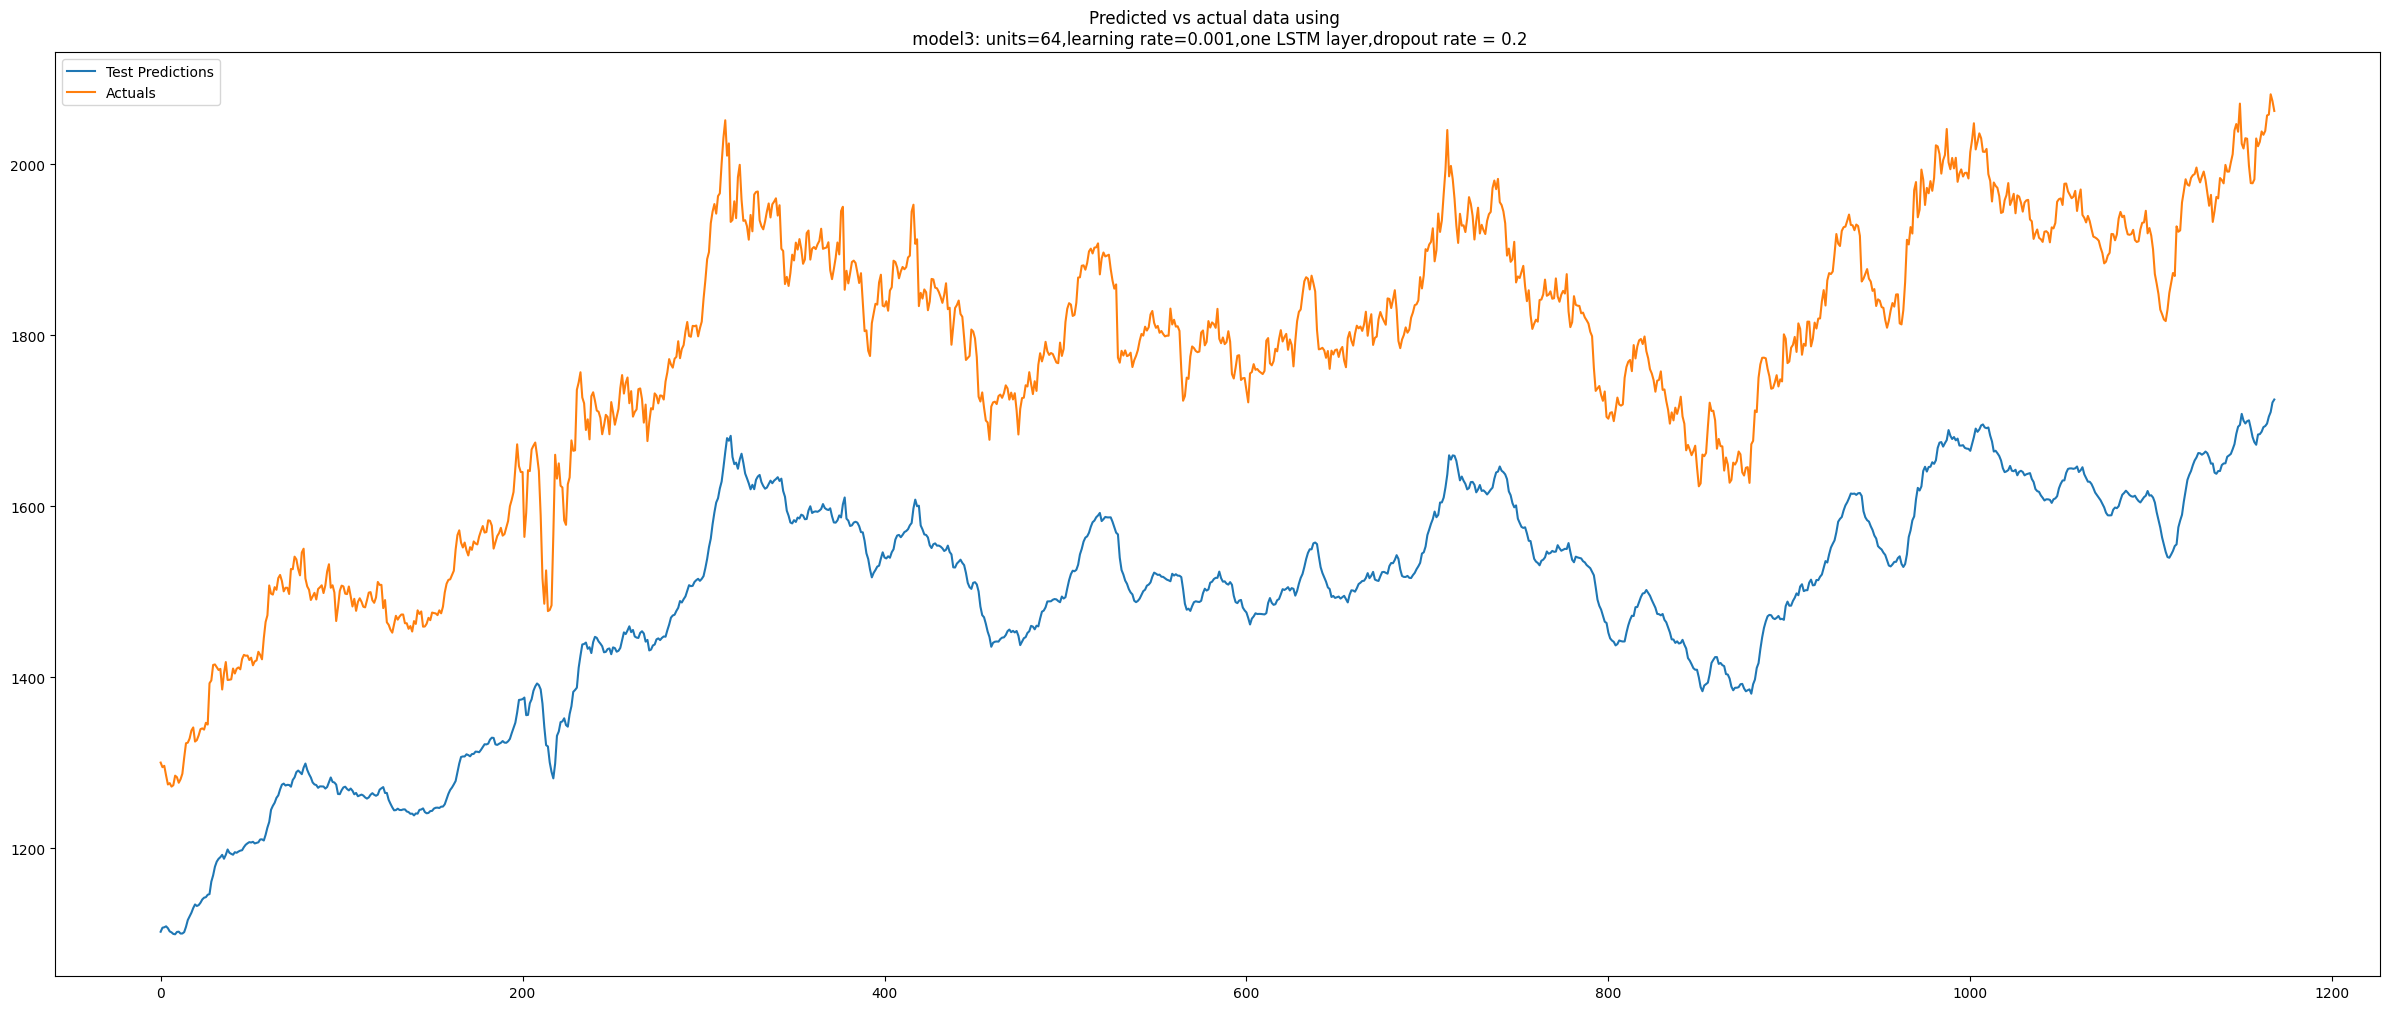

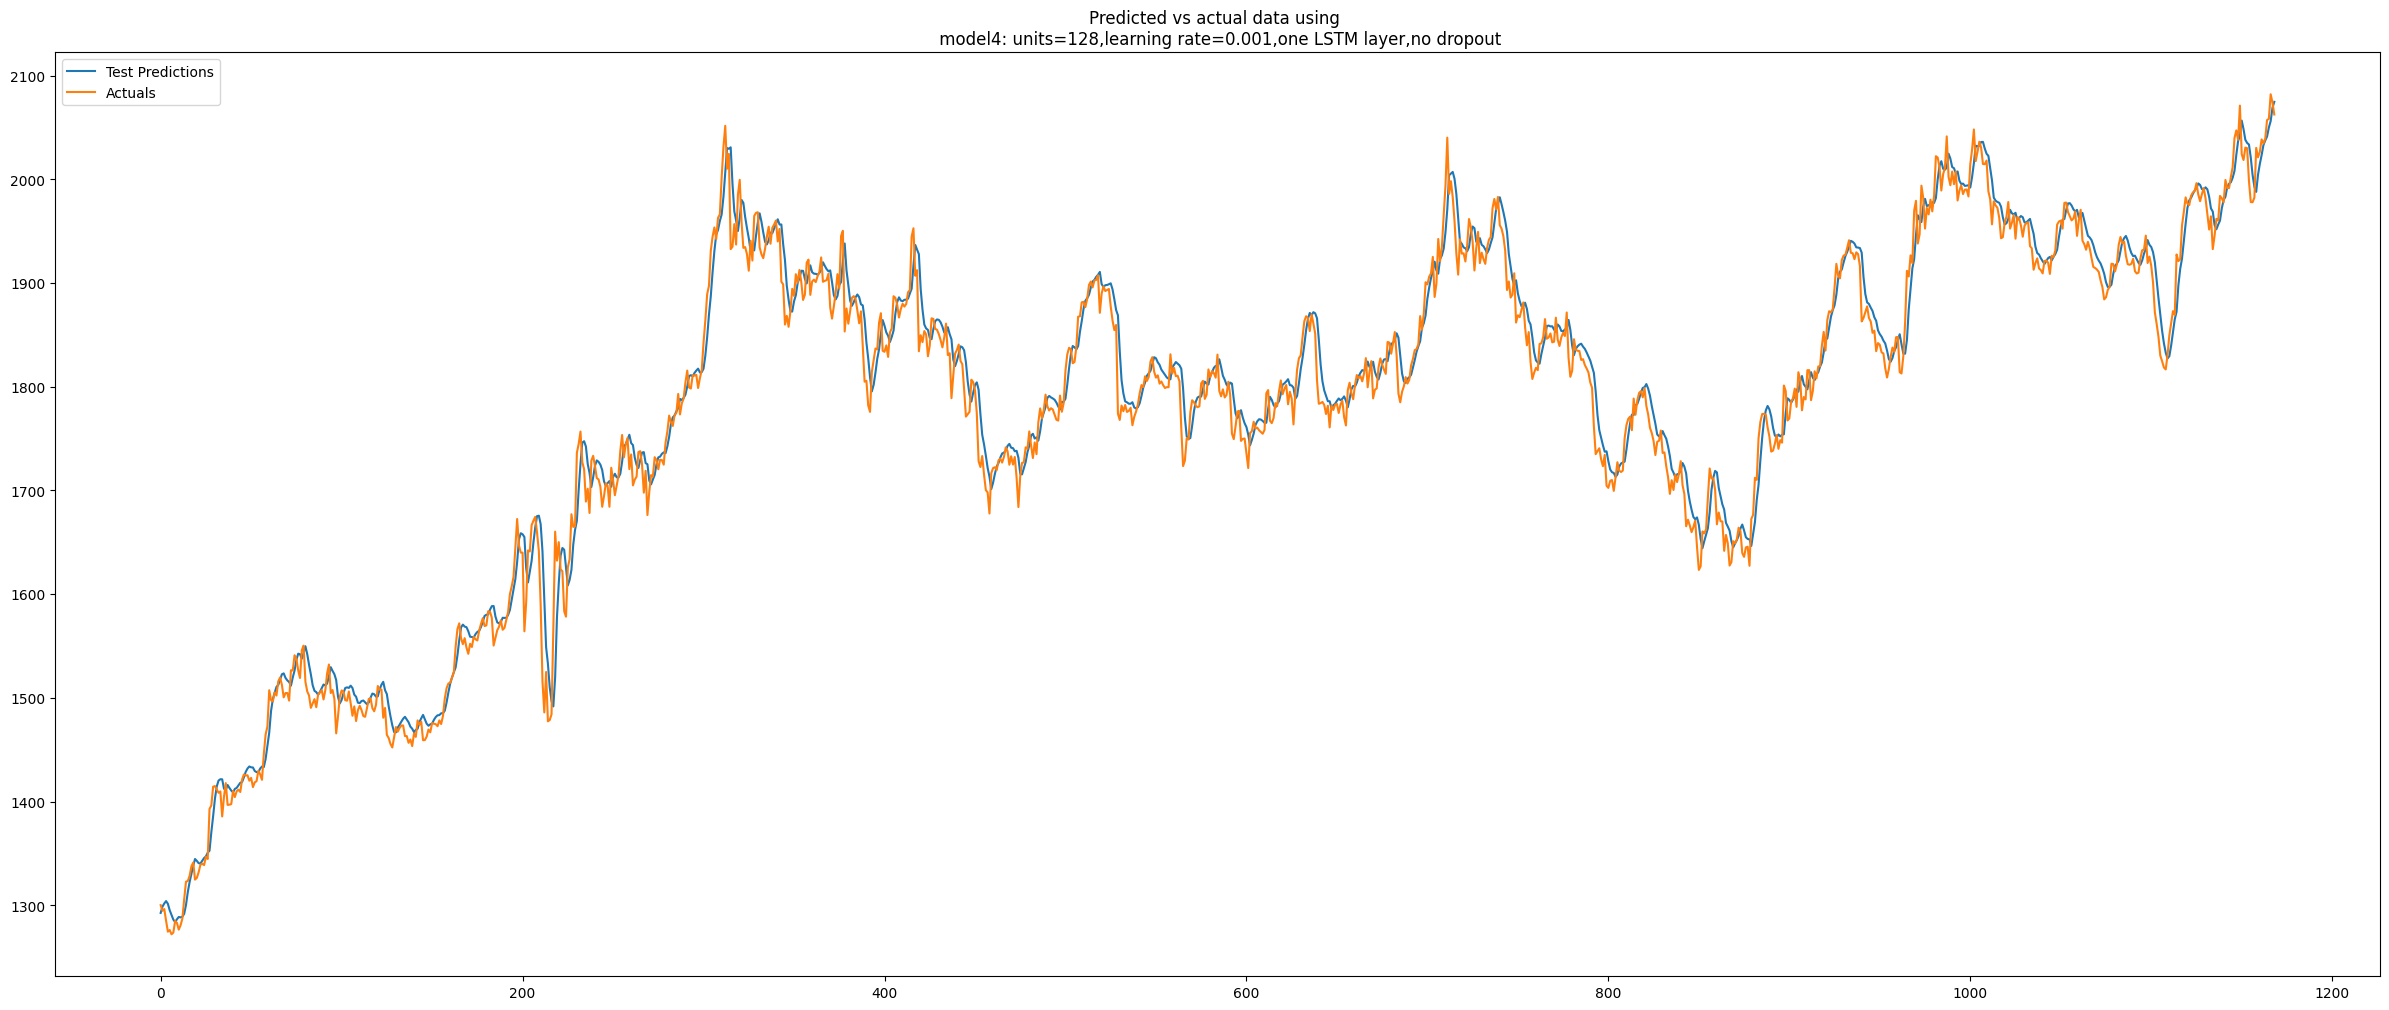

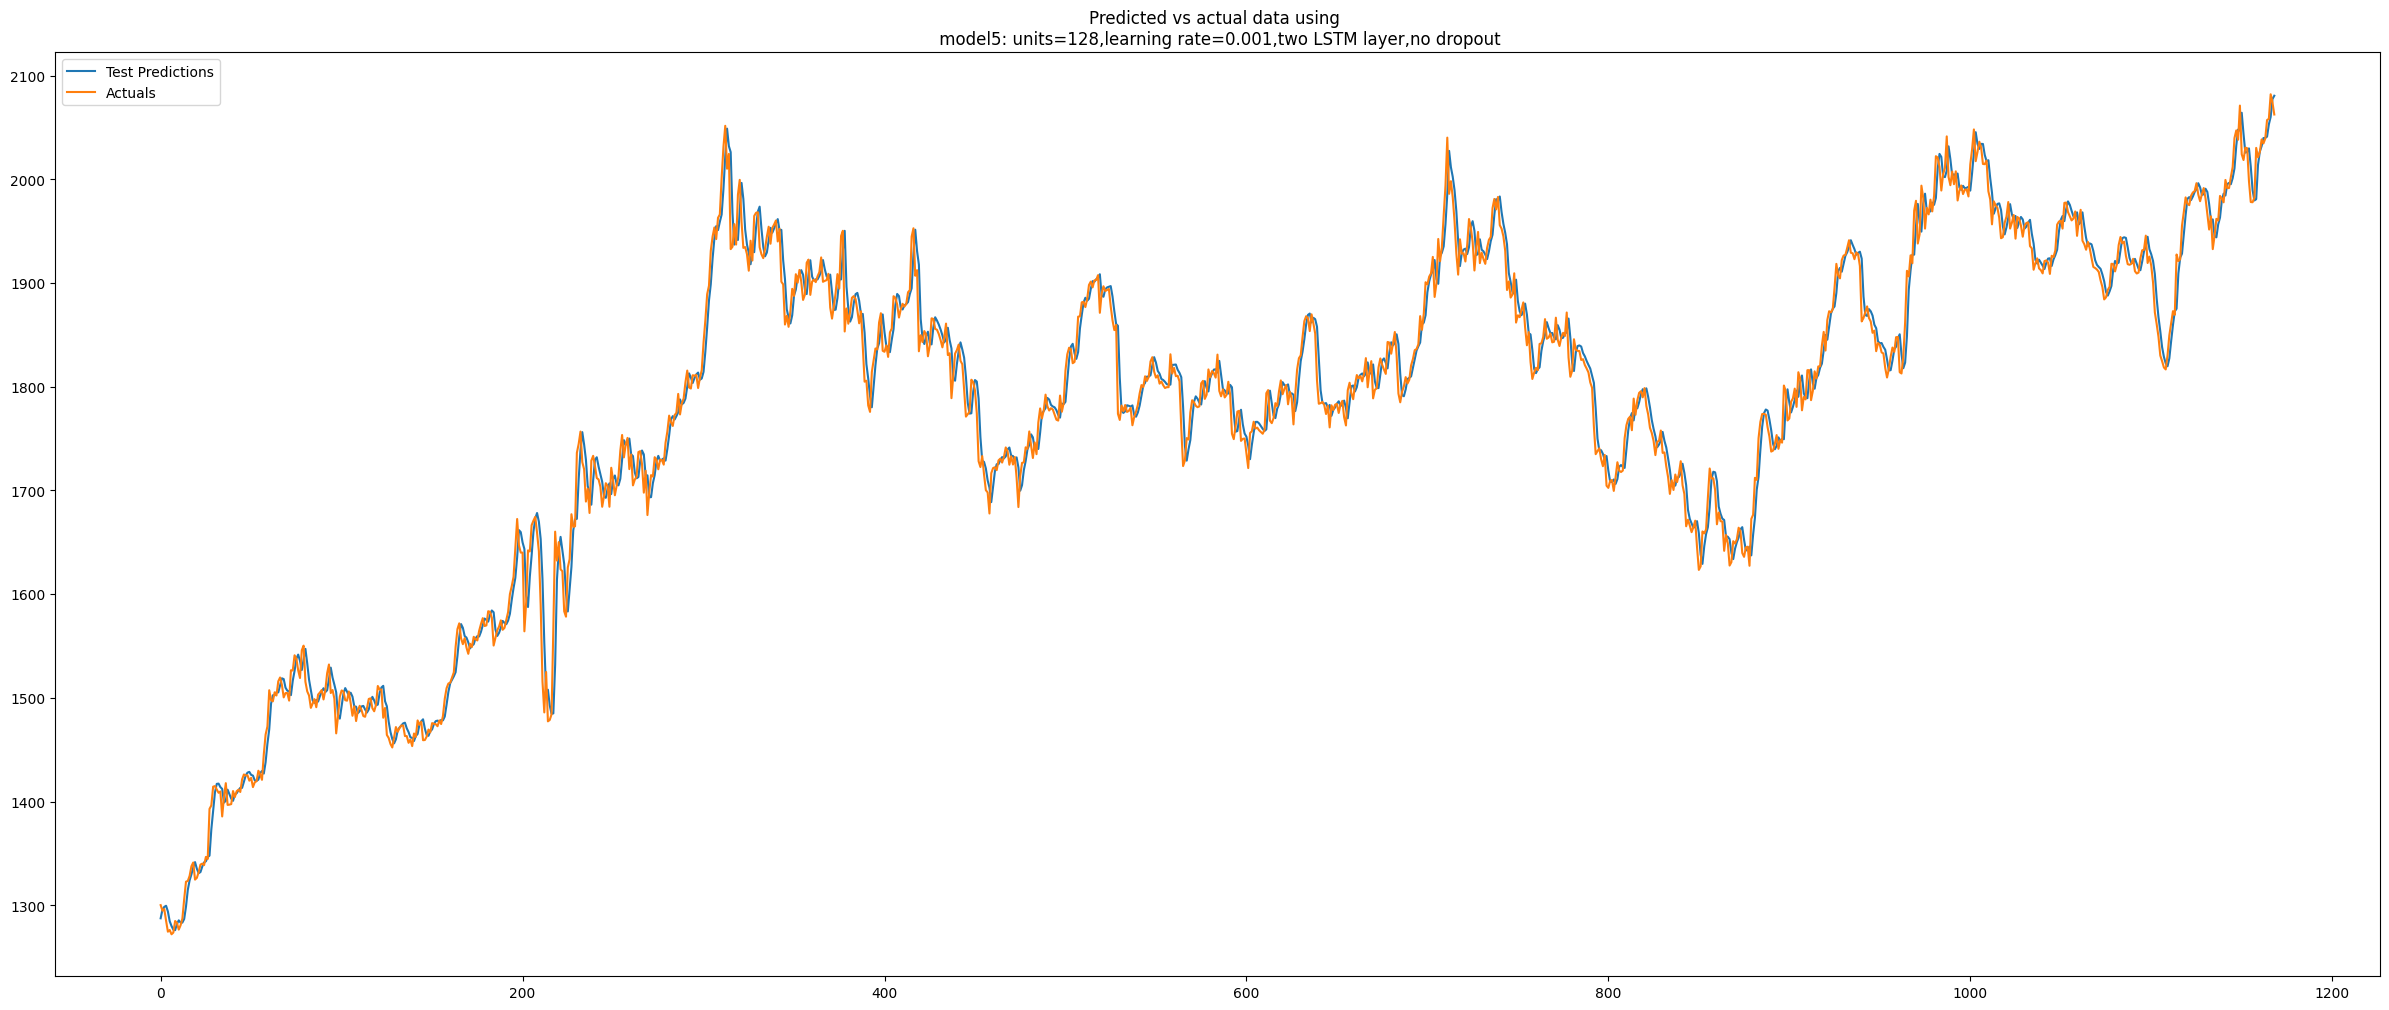

In [16]:
#Visualize the predicted gold prices alongside the actual gold prices
for pred,name in zip(test_predictions_per_model,names):

  plt.figure(figsize=(30, 12))
  plt.plot(pred, label='Test Predictions')
  plt.plot(Y, label='Actuals')
  plt.title(f'Predicted vs actual data using \n {name}')
  plt.legend()
  plt.show()
  print()

In [17]:
#Evaluate the model's performance using metrics like Mean Squared Error (MSE) or Root Mean Squared Error (RMSE)
for mse,rmse,name in zip(mse_vals,rmse_vals,names):
  print(f"{name} \n\n \tMean squared Error :{mse}\n \tRoot mean squared Error :{rmse}\n\n")

model1: units=64,learning rate=0.001,one LSTM layer,no dropout  

 	Mean squared Error :1169.630987697466
 	Root mean squared Error :34.199868240937214


model2: units=64,learning rate=0.0001,one LSTM layer,no dropout   

 	Mean squared Error :1628.759195760541
 	Root mean squared Error :40.35788889127553


model3: units=64,learning rate=0.001,one LSTM layer,dropout rate = 0.2 

 	Mean squared Error :83217.05538664464
 	Root mean squared Error :288.4736649793957


model4: units=128,learning rate=0.001,one LSTM layer,no dropout 

 	Mean squared Error :512.6432427582042
 	Root mean squared Error :22.641626327589726


model5: units=128,learning rate=0.001,two LSTM layer,no dropout 

 	Mean squared Error :376.7894248219001
 	Root mean squared Error :19.41106449481584




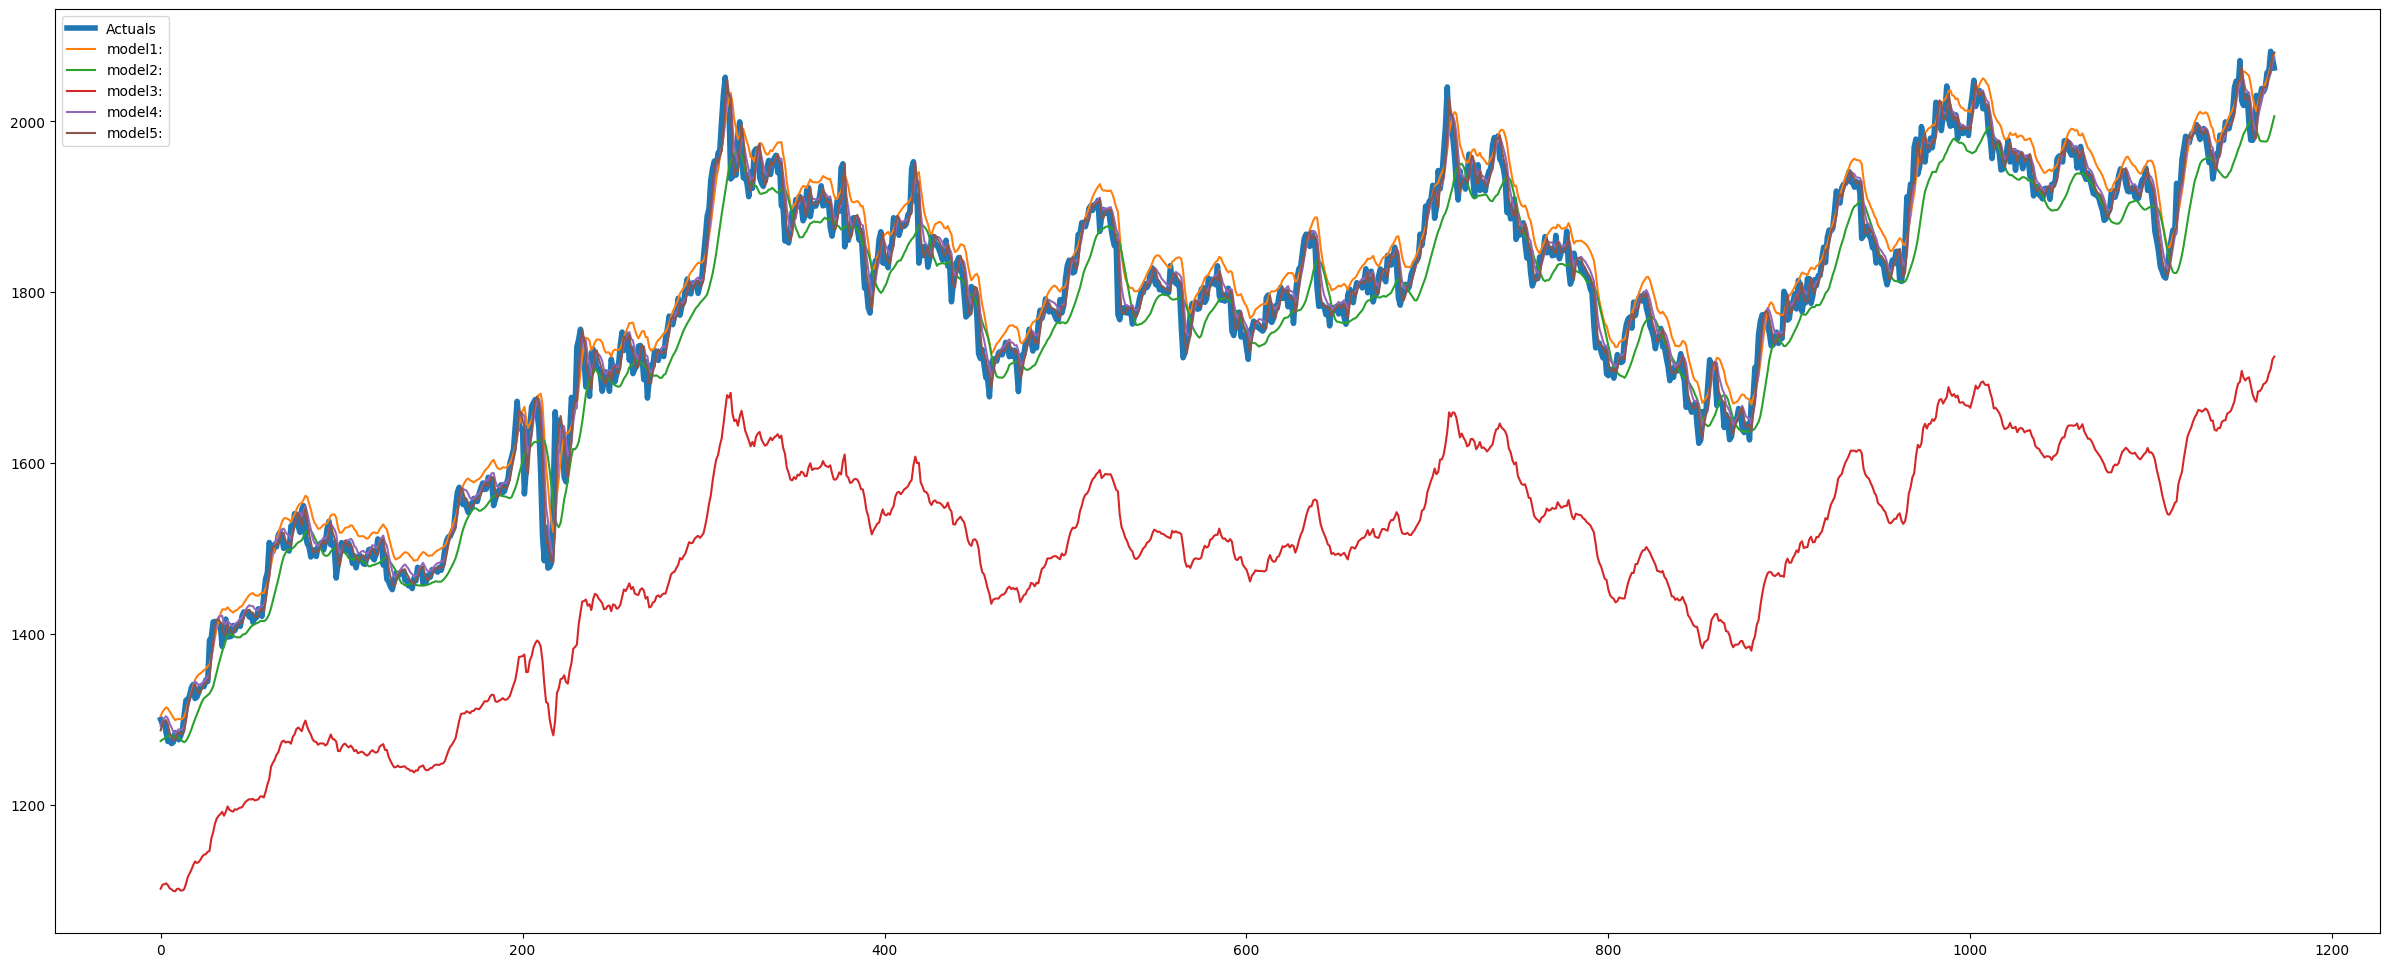

In [18]:
#plotting all models predictions on one plot
plt.figure(figsize=(30, 12))
plt.plot(Y, label='Actuals',linewidth=4)

for pred,name in zip(test_predictions_per_model,names):
  label  = name.split()[0]
  plt.plot(pred, label=label)

plt.legend()
plt.show()


In [19]:
def predict_between(start_date,end_date,model,name):
    gold_data = yf.download(ticker, start=start_date, end=end_date)
    gold_data.to_csv('temp.csv')
    df=pd.read_csv('temp.csv')
    df = df[['Date','Close']]

    df.index = pd.to_datetime(df['Date'],format="%Y-%m-%d")
    close_prices = df['Close'].values.reshape(-1, 1)
    scaled_close_prices = scaler.transform(close_prices)
    df['Scaled'] = scaled_close_prices
    df = df['Scaled']
    X,y = df_to_x_y(df,WINDOW_SIZE)
    predicted_scaled = model.predict(X).flatten()
    predicted_original = scaler.inverse_transform(predicted_scaled.reshape(-1, 1))
    predictions = predicted_original.flatten()

    y_flatten = y.flatten()
    correct_original = scaler.inverse_transform(y_flatten.reshape(-1, 1))
    Y = correct_original.flatten()

    results = pd.DataFrame(data={'Predictions':predictions, 'Actuals':Y})
    print(f"{name}\n\n")

    plt.figure(figsize=(30, 12))
    plt.plot(results['Predictions'], label='Predictions')
    plt.plot(results['Actuals'], label='Actuals')
    plt.legend()
    plt.show()

    mse = mean_squared_error(results['Actuals'],results['Predictions'])
    rmse = np.sqrt(mse)
    print(f"\n\nMean squared Error :{mse}\n Root mean squared Error :{rmse}\n\n")

[*********************100%%**********************]  1 of 1 completed

1/1 [==============================] - 0s 22ms/step


model1: units=64,learning rate=0.001,one LSTM layer,no dropout 




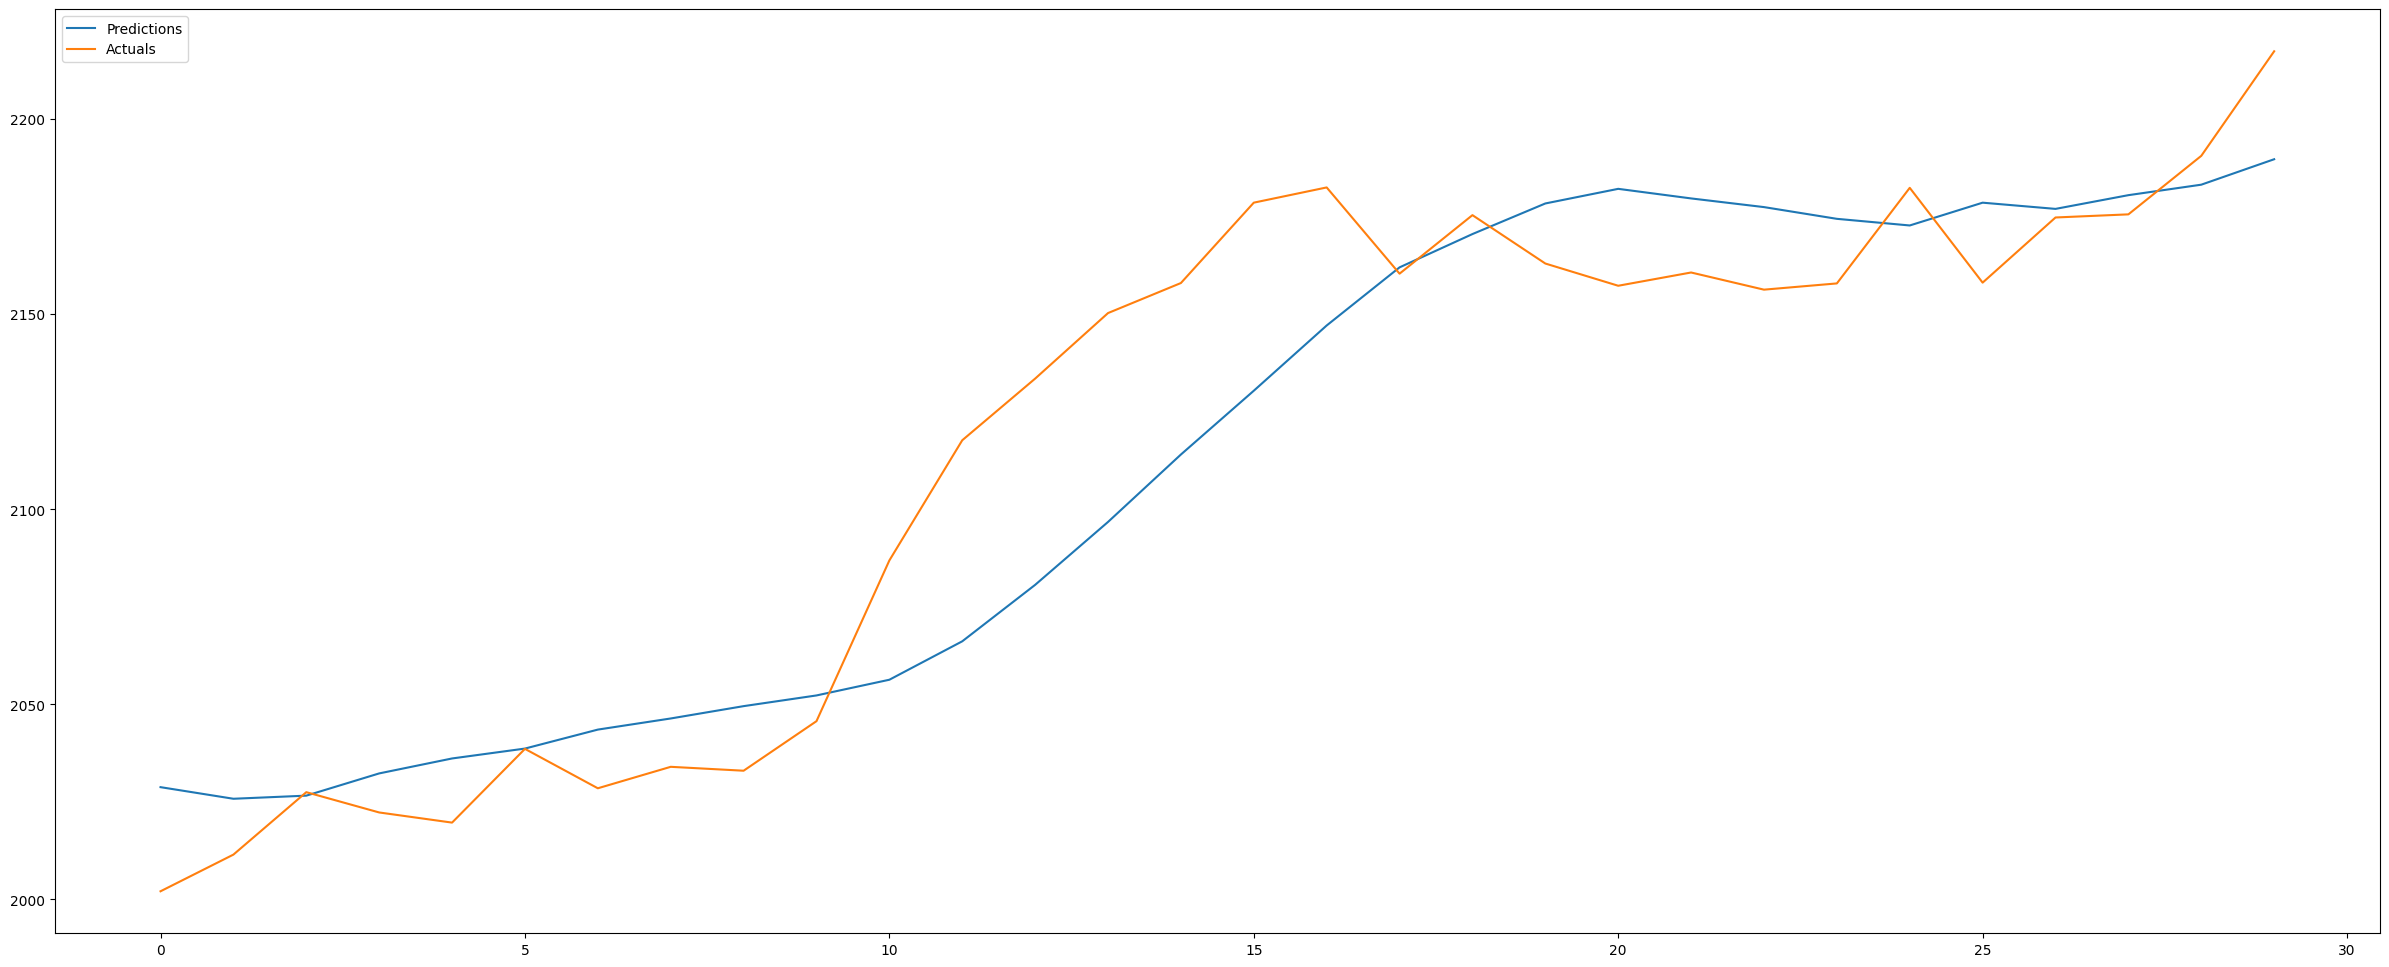

[*********************100%%**********************]  1 of 1 completed



Mean squared Error :668.9711767370502
 Root mean squared Error :25.864477120890154


1/1 [==============================] - 0s 27ms/step
model2: units=64,learning rate=0.0001,one LSTM layer,no dropout  




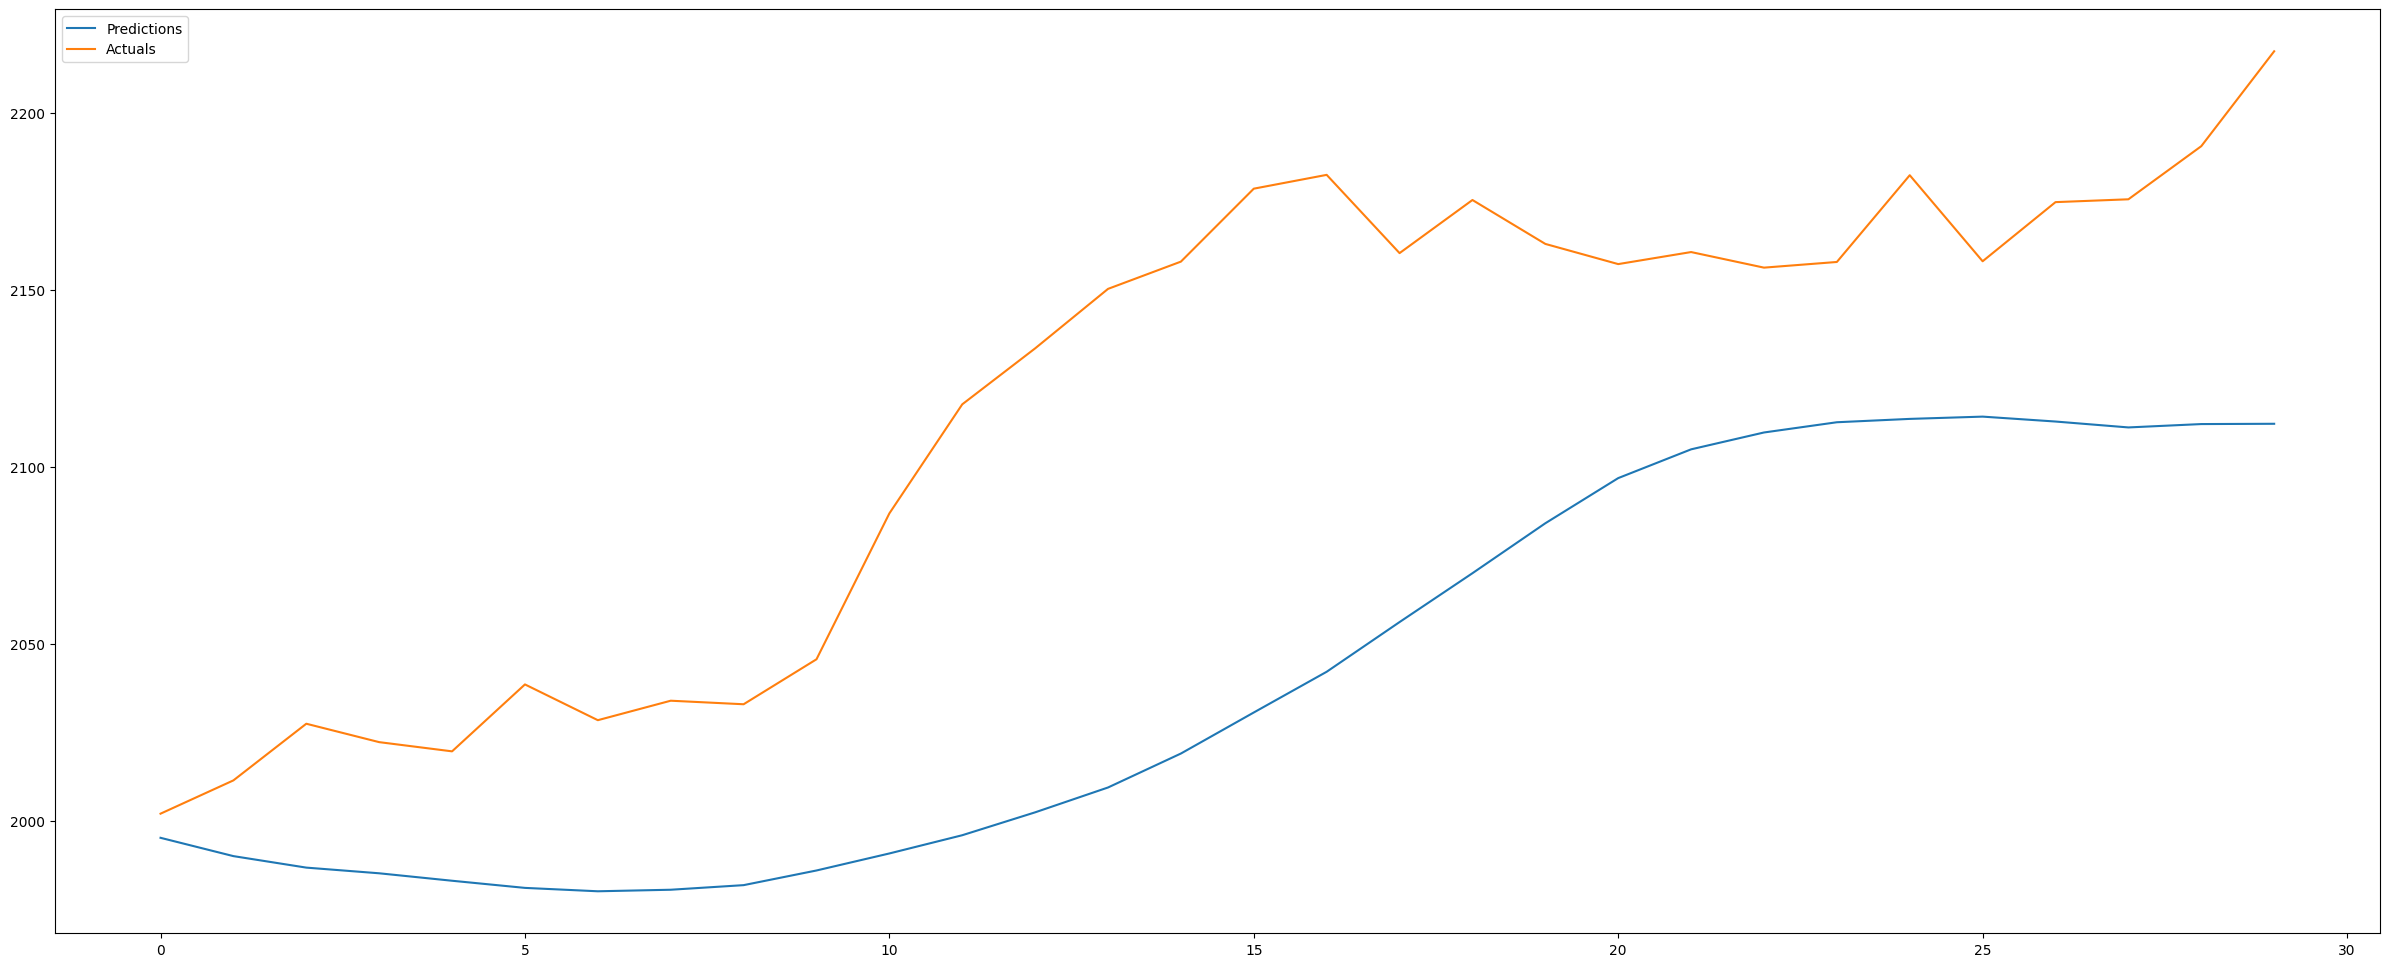

[*********************100%%**********************]  1 of 1 completed



Mean squared Error :7081.419014872611
 Root mean squared Error :84.15116763820102


1/1 [==============================] - 0s 22ms/step
model3: units=64,learning rate=0.001,one LSTM layer,dropout rate = 0.2




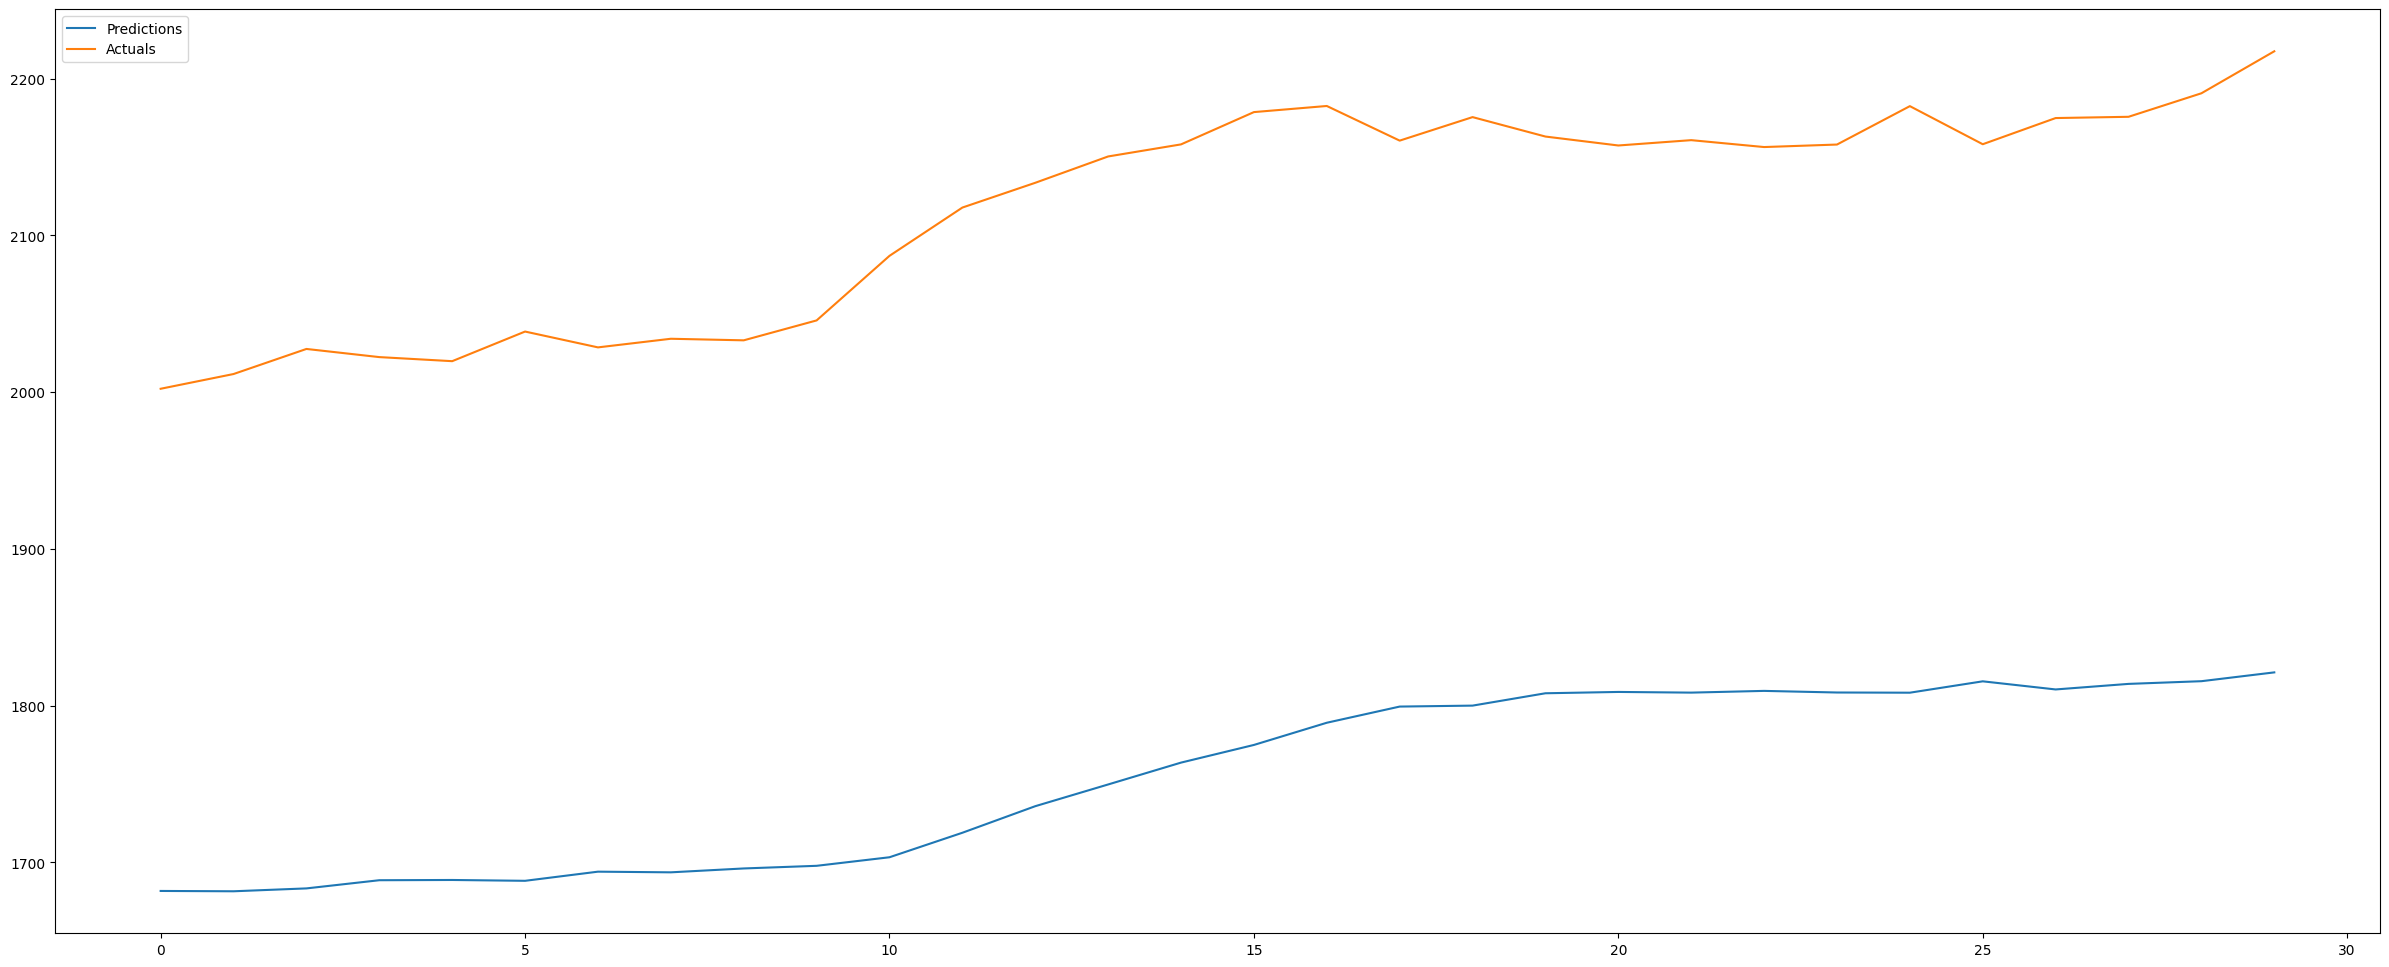

[*********************100%%**********************]  1 of 1 completed



Mean squared Error :131296.35975489567
 Root mean squared Error :362.34839554618657


1/1 [==============================] - 0s 23ms/step
model4: units=128,learning rate=0.001,one LSTM layer,no dropout




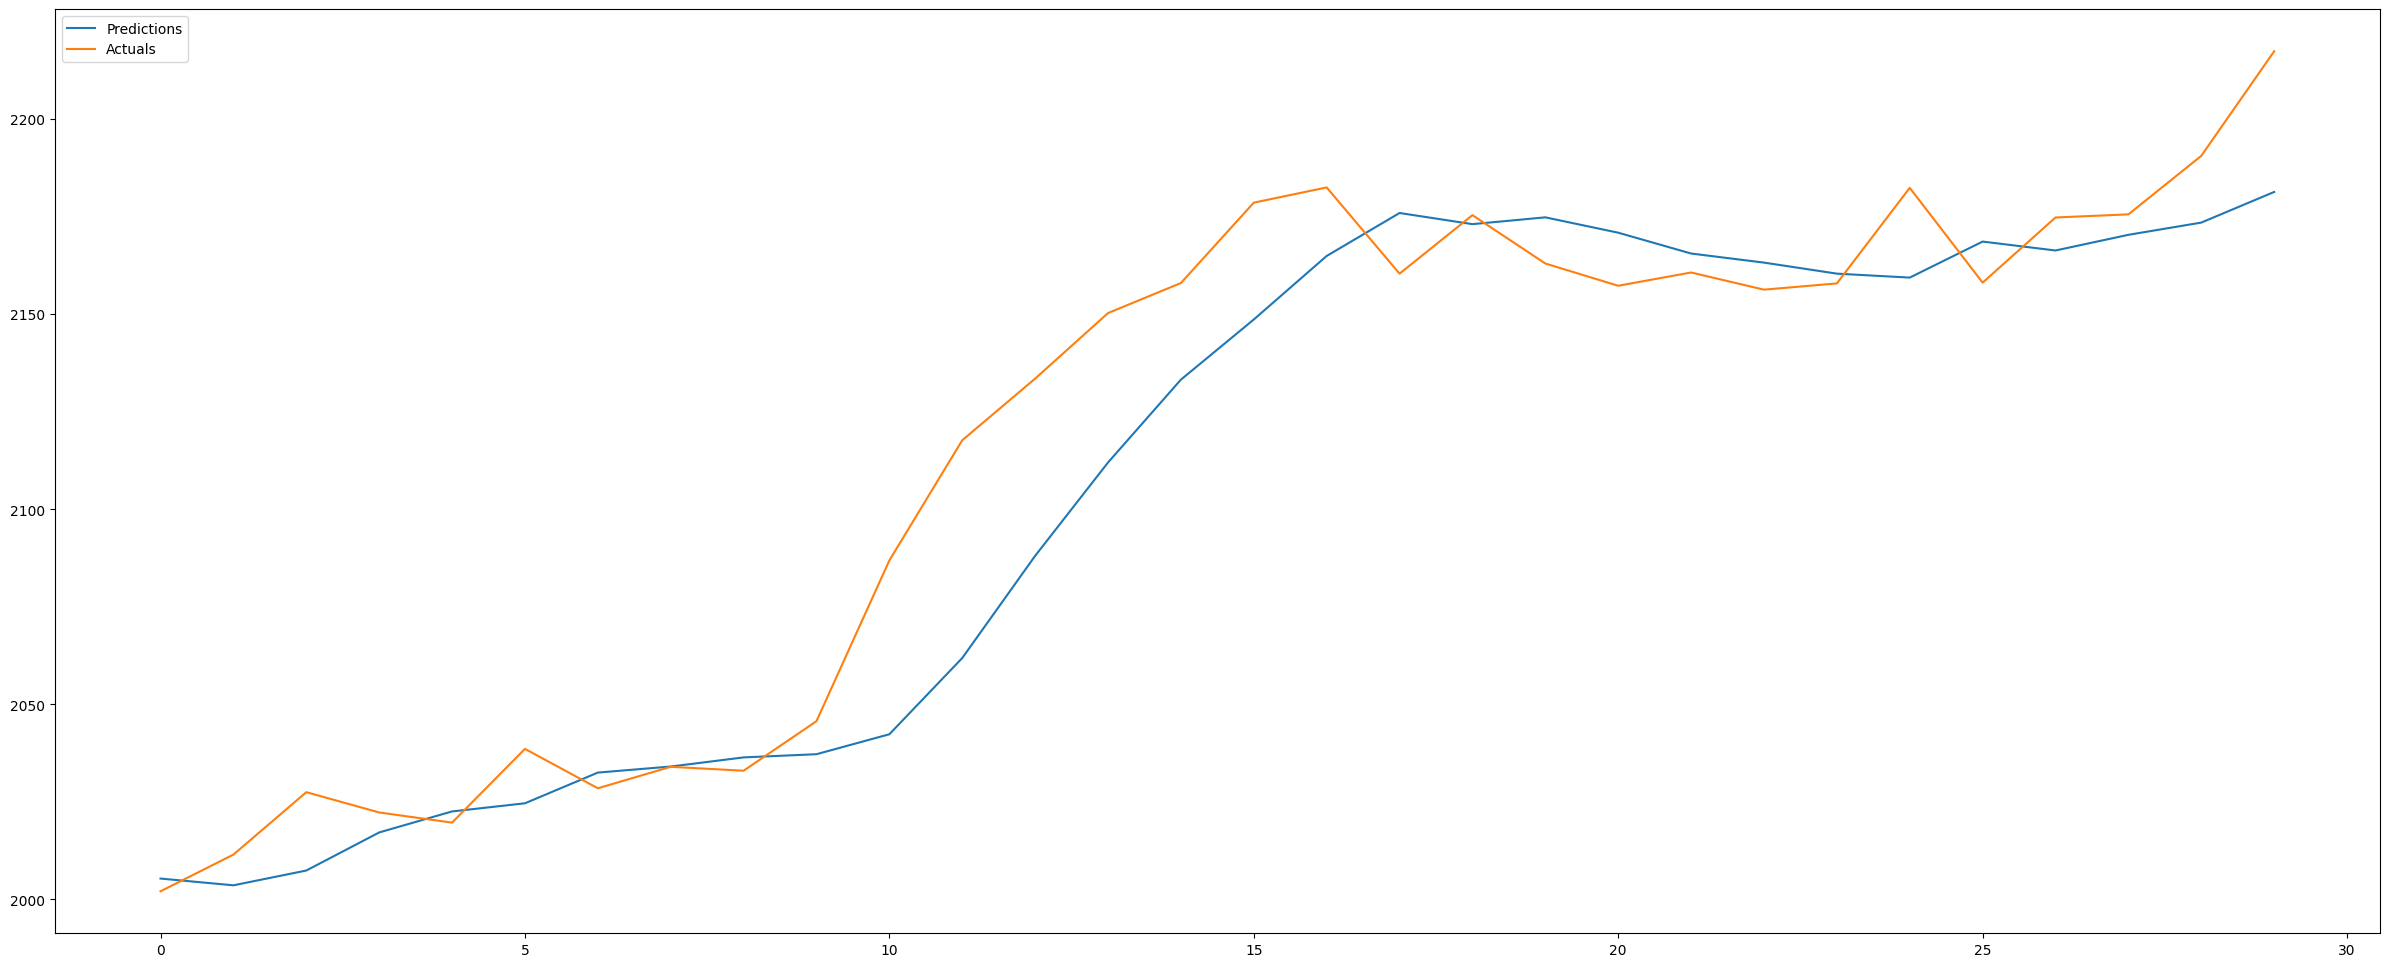

[*********************100%%**********************]  1 of 1 completed



Mean squared Error :474.52681843787406
 Root mean squared Error :21.783636483330188


1/1 [==============================] - 0s 27ms/step
model5: units=128,learning rate=0.001,two LSTM layer,no dropout




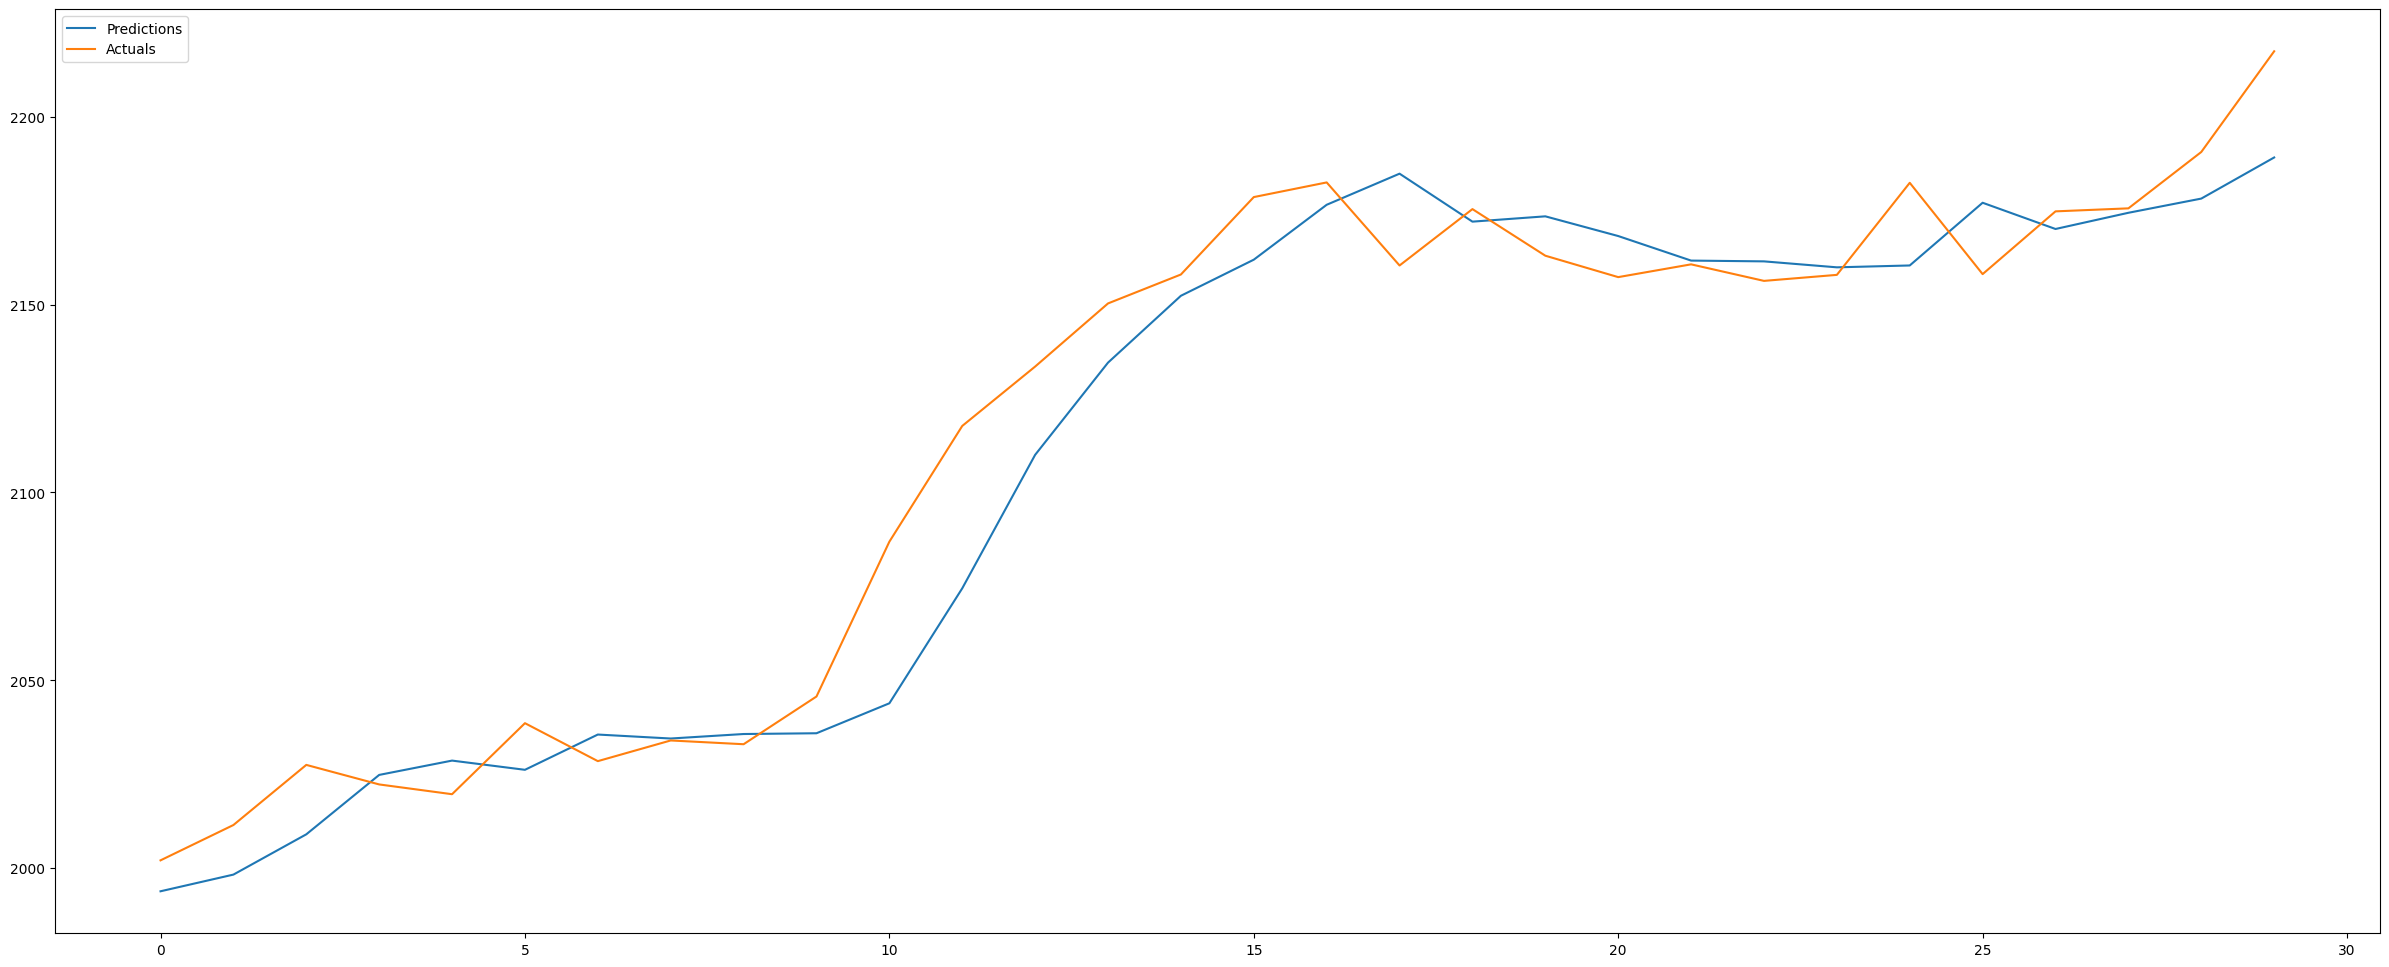



Mean squared Error :284.27867427766284
 Root mean squared Error :16.86056565710839




In [20]:
for model,name in zip(models,names):
  predict_between(start_date = '2024-02-01',end_date = '2024-04-01',model = model,name=name)